# Libraries and options

In [1]:
#pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
install.packages('jtools')

Installing package into ‘/home/olivier/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [3]:
# load LMER libraries
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(glmmTMB)
library(emmeans)
library(car)
library(DHARMa)
library(sjPlot) 
library(sjmisc)
library(sjlabelled)
library(effects)
library(performance)  # Loading the performance package
library(yaml)  # To load yaml config file
library(arrow) # To load feather file
library(jtools) # To report results
#library(equatiomatic) # Not in CRAN anymore need to wait for update here: https://github.com/datalorax/equatiomatic/issues/224

Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in checkMatrixPackageVersion():
“Package version inconsistency detected.
TMB was built with Matrix version 1.5.4.1
Current Matrix version is 1.6.1
Please re-install 'TMB' from source using install.packages('TMB', type = 'source') or ask CRAN for a binary version of 'TMB' matching CRAN's 'Matrix' package”
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')


Attaching package: ‘sjlabelled’


The following 

In [4]:

browser = '/usr/bin/firefox'

utils::browseURL

function (url, browser = getOption("browser"), encodeIfNeeded = FALSE) 
{
    WINDOWS <- .Platform$OS.type == "windows"
    if (!is.character(url) || length(url) != 1L || !nzchar(url)) 
        stop("'url' must be a non-empty character string")
    if (identical(browser, "false")) 
        return(invisible())
    if (WINDOWS && is.null(browser)) 
        return(shell.exec(url))
    if (is.function(browser)) 
        return(invisible(browser(if (encodeIfNeeded) URLencode(url) else url)))
    if (!is.character(browser) || length(browser) != 1L || !nzchar(browser)) 
        stop("'browser' must be a non-empty character string")
    if (WINDOWS) {
        return(system(paste0("\"", browser, "\" ", if (encodeIfNeeded) URLencode(url) else url), 
            wait = FALSE))
    }
    if (.Platform$GUI == "AQUA" || length(grep("^(localhost|):", 
        Sys.getenv("DISPLAY")))) 
        isLocal <- TRUE
    else isLocal <- FALSE
    .shQuote <- function(string) paste0("\"", gsub("$", "\\$", 
        string, fixed = TRUE), "\"")
    quotedUrl <- .shQuote(if (encodeIfNeeded) 
        URLencode(url)
    else url)
    remoteCmd <- if (isLocal) 
        switch(basename(browser), `gnome-moz-remote` = , open = quotedUrl, 
            galeon = paste("-x", quotedUrl), kfmclient = paste("openURL", 
                quotedUrl), mozilla = , opera = {
                paste0("-remote \"openURL(", gsub("([,)$])", 
                  "%\\1", url), ")\"")
            }, quotedUrl)
    else quotedUrl
    system(paste(browser, remoteCmd, "> /dev/null 2>&1 ||", browser, 
        quotedUrl, "&"))
}
<environment: namespace:utils>

# Loading data

In [5]:
# Load the configuration file
config_path <- './config/config.yaml'
config <- tryCatch(
  yaml::read_yaml(config_path),
  error = function(e) {
    stop("Error reading YAML file: ", e$message)
  }
)

# Extract relevant information from the configuration
sample_size <- config$datasets$sample_size
final_data_folder <- config$datasets$pickle_folder
df_R_data_filename <- config$datasets$df_R_filename

# Construct the final data file path
df_R_data_file <- paste0(df_R_data_filename, "_", sample_size, ".feather")
final_data_location <- file.path(final_data_folder, df_R_data_file)


# Print the final data file location

# Read the Feather file
df <- arrow::read_feather(final_data_location)
str(df)

tibble [49,994 × 42] (S3: tbl_df/tbl/data.frame)
 $ t_id                    : chr [1:49994] "1575251731515994114" "1443224010930614272" "1574874734034034706" "1575552603152257025" ...
 $ t_text                  : chr [1:49994] "Bingo. And it’s not just the hijab… But birth control and abortion and driving laws and divorce. It’s almost li"| __truncated__ "So weird how San Francisco tech bros are moving to places where abortion is (or is about to be) illegal 🧐" "In 2019, #DougMastriano said women who violated proposed abortion ban should be charged with murder. #GOPWarOnW"| __truncated__ "\"It's a really strong step forward if the goal is to make California sort of this sanctuary state for abortion"| __truncated__ ...
 $ t_retweet_count         : int [1:49994] 0 0 0 6 7 25 0 0 0 12 ...
 $ t_reply_count           : int [1:49994] 0 0 0 0 0 7 0 0 2 2 ...
 $ t_like_count            : int [1:49994] 3 3 0 18 25 67 0 1 6 28 ...
 $ t_quote_count           : int [1:49994] 0 0 0 3 0 3 0 0 2 1 ...


In [6]:
result <- table(df$category)

# To display the result
print(result)


   abortion        both miscarriage     neither 
      37862         333        3169        8630 


## Subsetting the df to only use the including

In [7]:
df <- df[df$analysis, ]
df <- droplevels(df)

## Setting variables type

In [8]:
# Refactoring 
df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_year <- relevel(df$t_year, ref = '2021')
df$t_event_noyear <- as.factor(df$t_event_noyear)
df$t_event <- as.factor(df$t_event)
df$a_gender <- relevel(as.factor(df$a_gender), ref = "Woman")
df$category <- as.factor(df$category)

# Retweet analysis

## Formula

In [9]:
DV = "t_retweet_count_agg"

In [10]:
# Unadjusted formula with only the main interaction
unadjusted_formula_string = paste(DV, " ~ poly(t_polarity, 3)+  + t_subjectivity + a_gender + +t_year + category + (1| a_id)")
unadjusted_formula <- as.formula(unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand"
complete_adjusted_formula_string = paste0(unadjusted_formula_string, adjusted_formula_string)
adjusted_formula <- as.formula(complete_adjusted_formula_string)

# Full interactions formula
full_formula_string <- "+ poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender + poly(t_polarity, 3):t_year + poly(t_polarity, 3):category  + t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category"
complete_full_formula_string <- paste0(unadjusted_formula_string, adjusted_formula_string, full_formula_string)

full_formula <- as.formula(complete_full_formula_string)

## Poisson

### Unadjusted

In [11]:
poisson.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.unadjusted)
check_zeroinflation(poisson.unadjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      6.089
  Pearson's Chi-Squared = 175726.827
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19308
            Ratio: 1.03


### Adjusted

In [12]:
poisson.adjusted <- glmmTMB(adjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.adjusted)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      6.093
  Pearson's Chi-Squared = 175800.681
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19245
            Ratio: 1.02


### Full model

In [13]:
poisson.adjusted_full <- update(poisson.adjusted, full_formula)
check_overdispersion(poisson.adjusted_full)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      5.693
  Pearson's Chi-Squared = 164185.420
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19245
            Ratio: 1.02


## Negative binomial

### Unadjusted model

In [14]:
neg_bin.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "nbinom2")
check_overdispersion(neg_bin.unadjusted)
check_zeroinflation(neg_bin.unadjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.264
  Pearson's Chi-Squared = 7608.738
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 20221
            Ratio: 1.07


### Adjusted model

In [15]:
neg_bin.adjusted <- update(neg_bin.unadjusted, adjusted_formula)
check_overdispersion(neg_bin.adjusted)
check_zeroinflation(neg_bin.adjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.273
  Pearson's Chi-Squared = 7886.553
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 20129
            Ratio: 1.07


## Full model

In [16]:
neg_bin.adjusted_full <- update(neg_bin.adjusted, full_formula)
check_overdispersion(neg_bin.adjusted_full)
summary(neg_bin.adjusted_full)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.274
  Pearson's Chi-Squared = 7890.664
                p-value =        1


 Family: nbinom2  ( log )
Formula:          t_retweet_count_agg ~ poly(t_polarity, 3) + t_subjectivity +  
    a_gender + t_year + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + a_listed_count_stand +  
    poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender +  
    poly(t_polarity, 3):t_year + poly(t_polarity, 3):category +  
    t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
 92306.3  92546.1 -46124.2  92248.3    28838 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.744    2.783   
Number of obs: 28867, groups:  a_id, 22973

Dispersion parameter for nbinom2 family (): 1.23 

Conditional model:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -2.52359    0.07384  -34.18  < 2e-16
poly(t_polarity, 3)1               

## Anova

In [17]:
anova(neg_bin.unadjusted, neg_bin.adjusted, neg_bin.adjusted_full)

Df AIC      BIC      logLik    deviance Chisq      Chi Df
neg_bin.unadjusted    10 93613.17 93695.87 -46796.58 93593.17         NA NA    
neg_bin.adjusted      14 92314.75 92430.54 -46143.38 92286.75 1306.41537  4    
neg_bin.adjusted_full 29 92306.31 92546.15 -46124.15 92248.31   38.44618 15    
                      Pr(>Chisq)   
neg_bin.unadjusted               NA
neg_bin.adjusted      1.352766e-281
neg_bin.adjusted_full  7.749108e-04

## Best model

In [18]:
best_model <- neg_bin.adjusted_full

In [19]:
summary(best_model)

 Family: nbinom2  ( log )
Formula:          t_retweet_count_agg ~ poly(t_polarity, 3) + t_subjectivity +  
    a_gender + t_year + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + a_listed_count_stand +  
    poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender +  
    poly(t_polarity, 3):t_year + poly(t_polarity, 3):category +  
    t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
 92306.3  92546.1 -46124.2  92248.3    28838 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.744    2.783   
Number of obs: 28867, groups:  a_id, 22973

Dispersion parameter for nbinom2 family (): 1.23 

Conditional model:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -2.52359    0.07384  -34.18  < 2e-16
poly(t_polarity, 3)1               

In [20]:
# Generate effects
effect_plot <- allEffects(best_model)

Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Eff

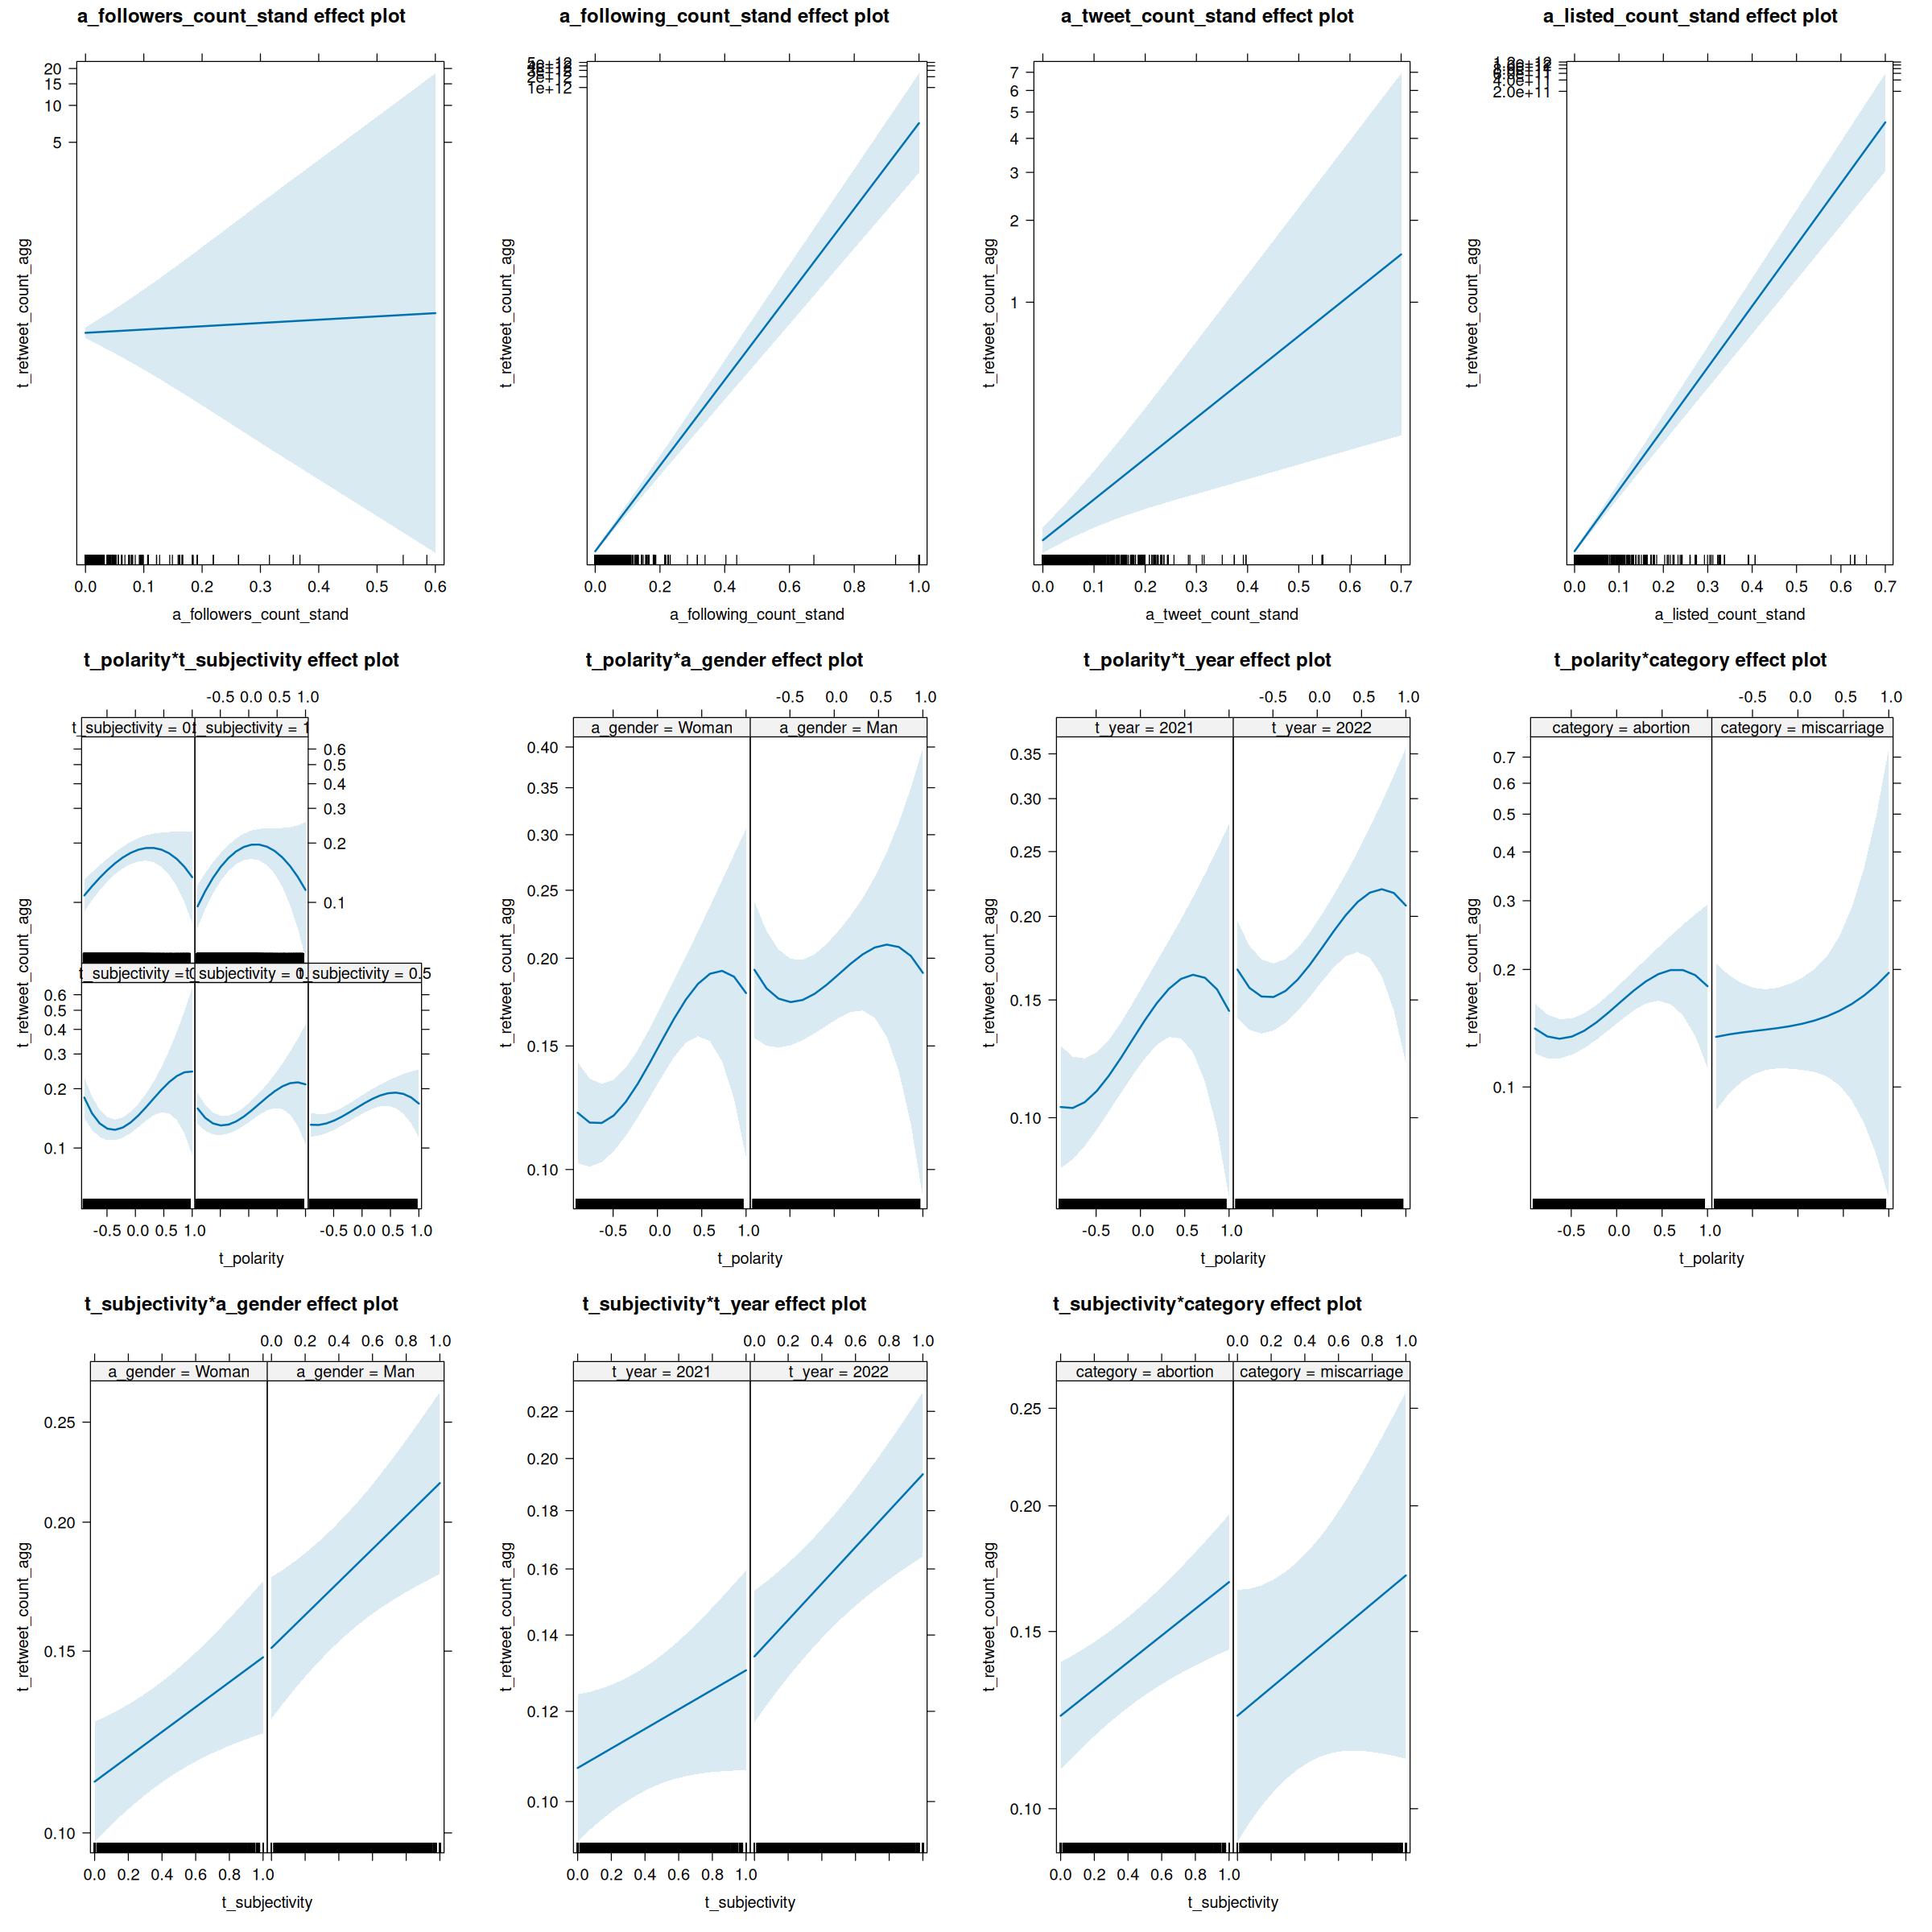

In [21]:
options(repr.plot.width=20, repr.plot.height=20)
plot(effect_plot)

In [22]:
best_model_output <- simulateResiduals(fittedModel = best_model)

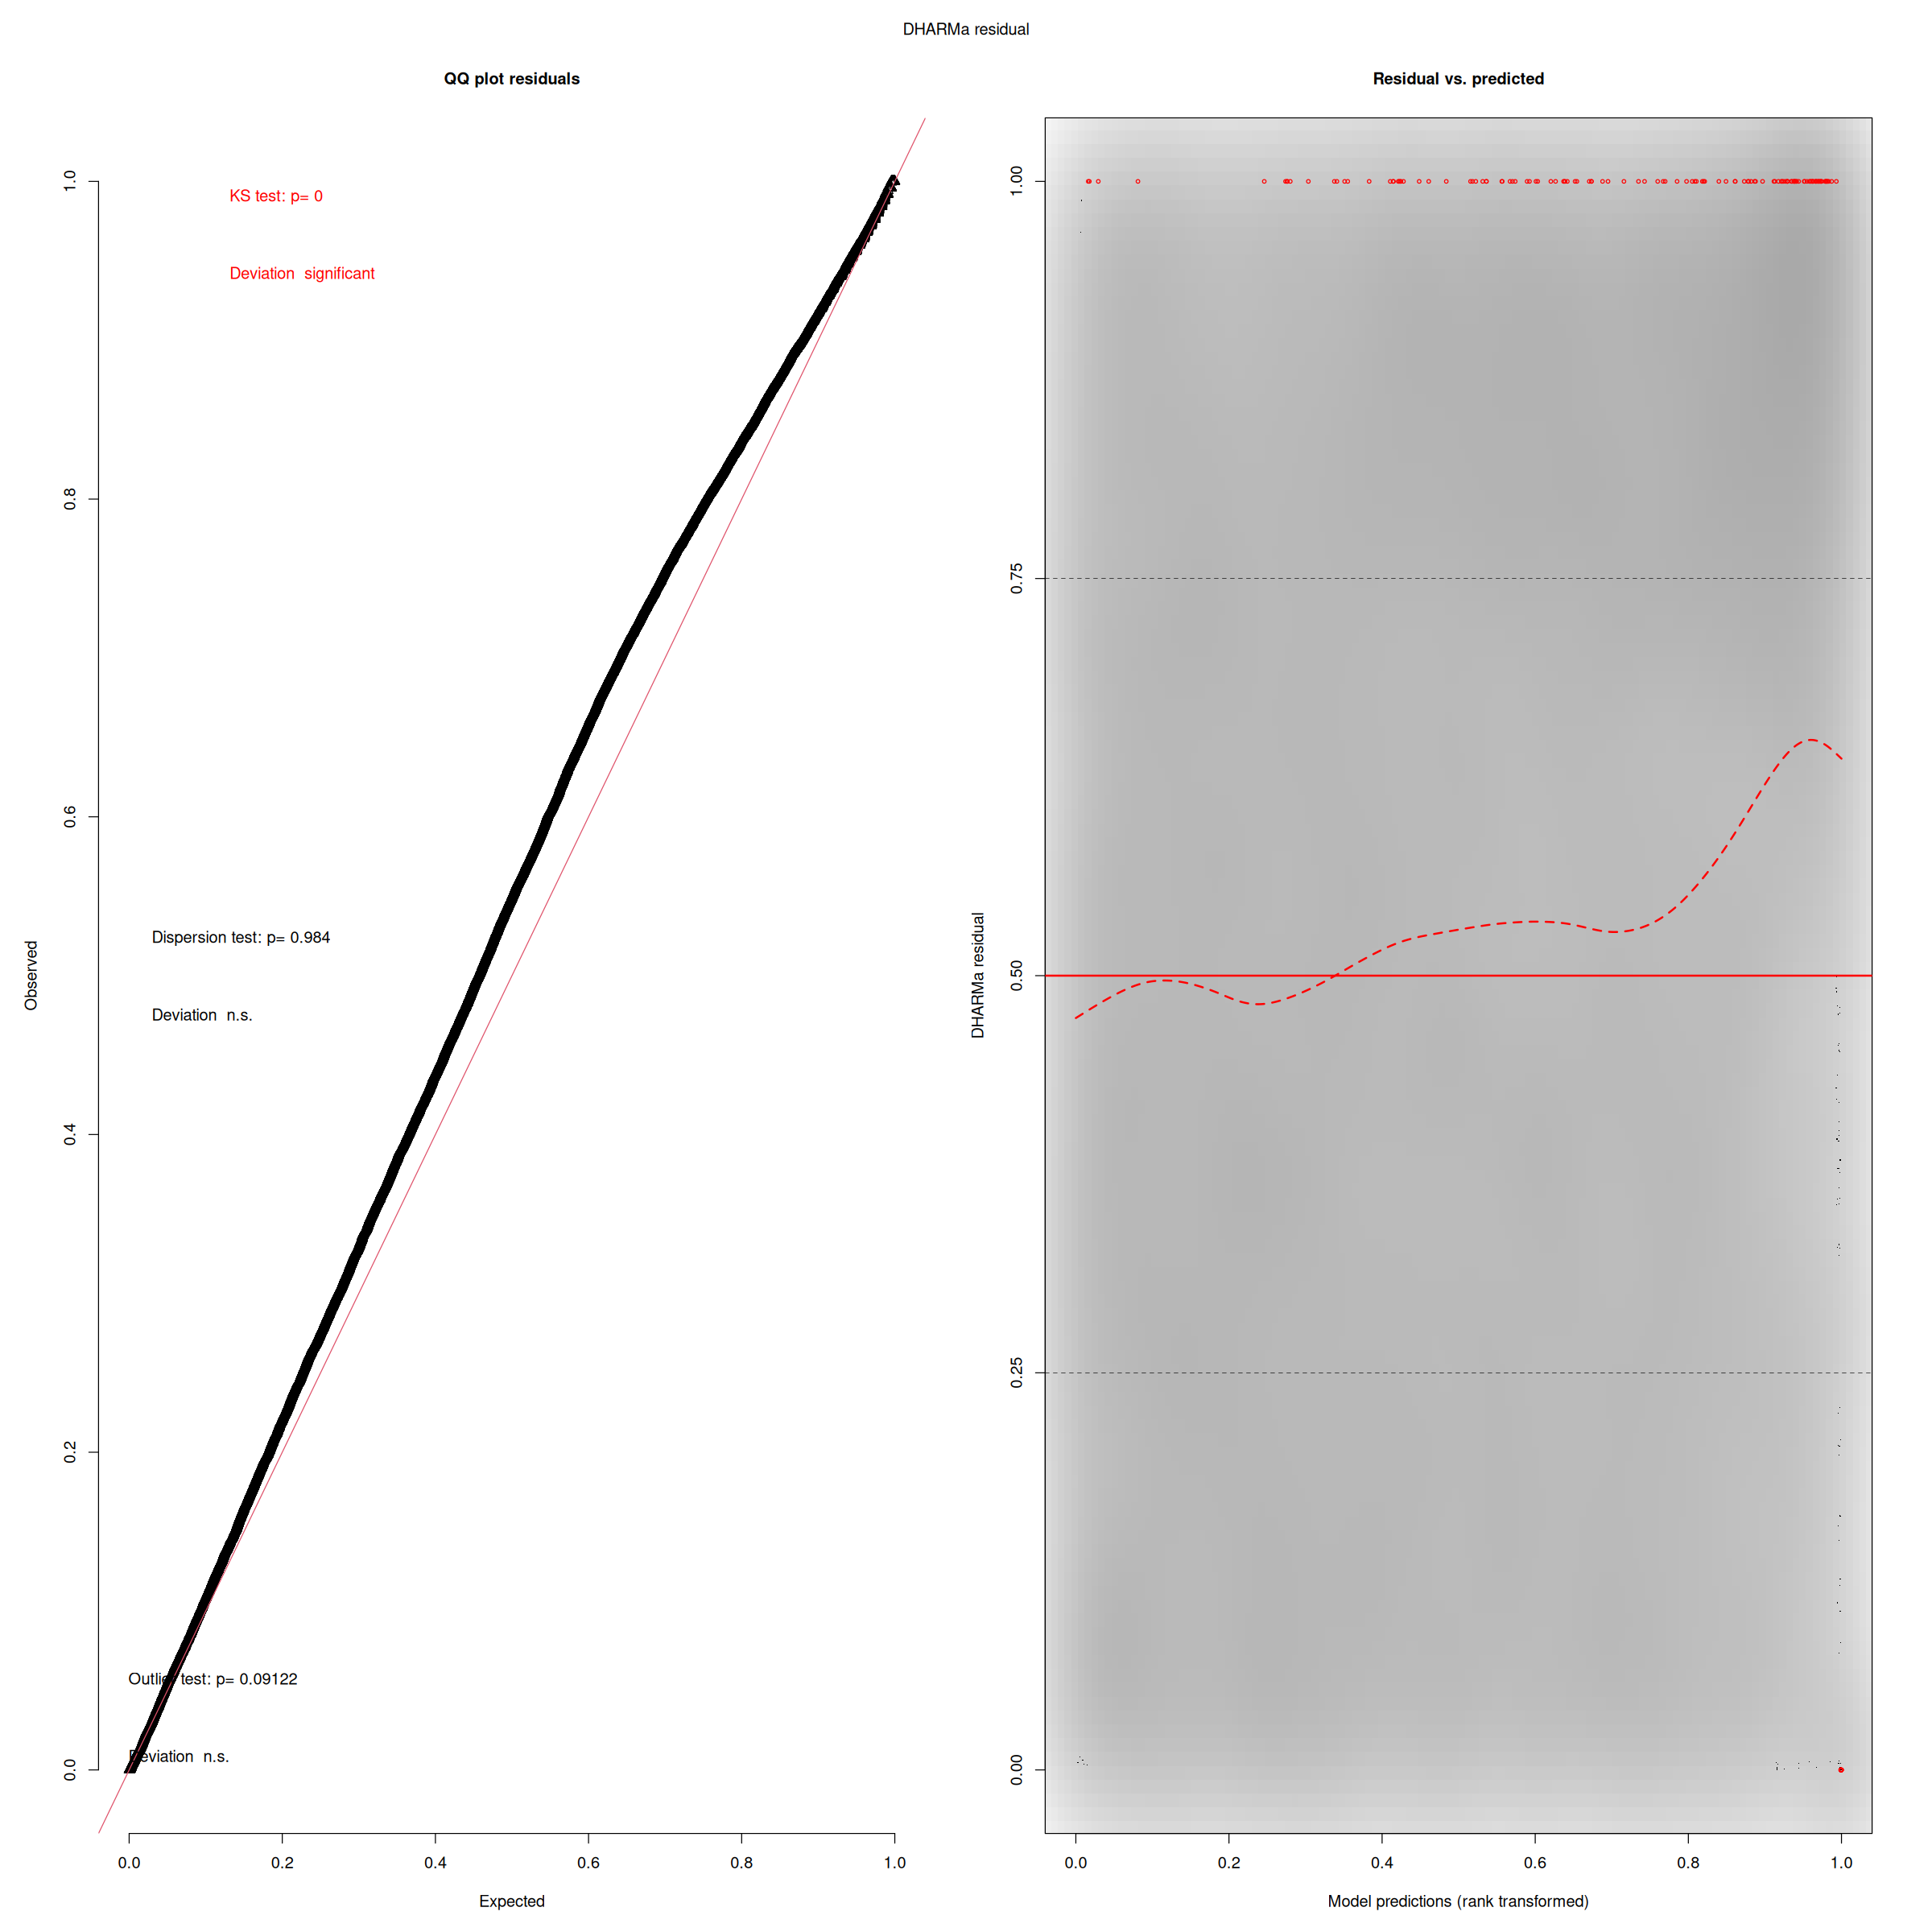

In [23]:
plot(best_model_output)


	DHARMa bootstrapped outlier test

data:  best_model_output
outliers at both margin(s) = 149, observations = 28867, p-value = 0.08
alternative hypothesis: two.sided
 percent confidence interval:
 0.005023037 0.007347490
sample estimates:
outlier frequency (expected: 0.0062472719714553 ) 
                                      0.005161603 


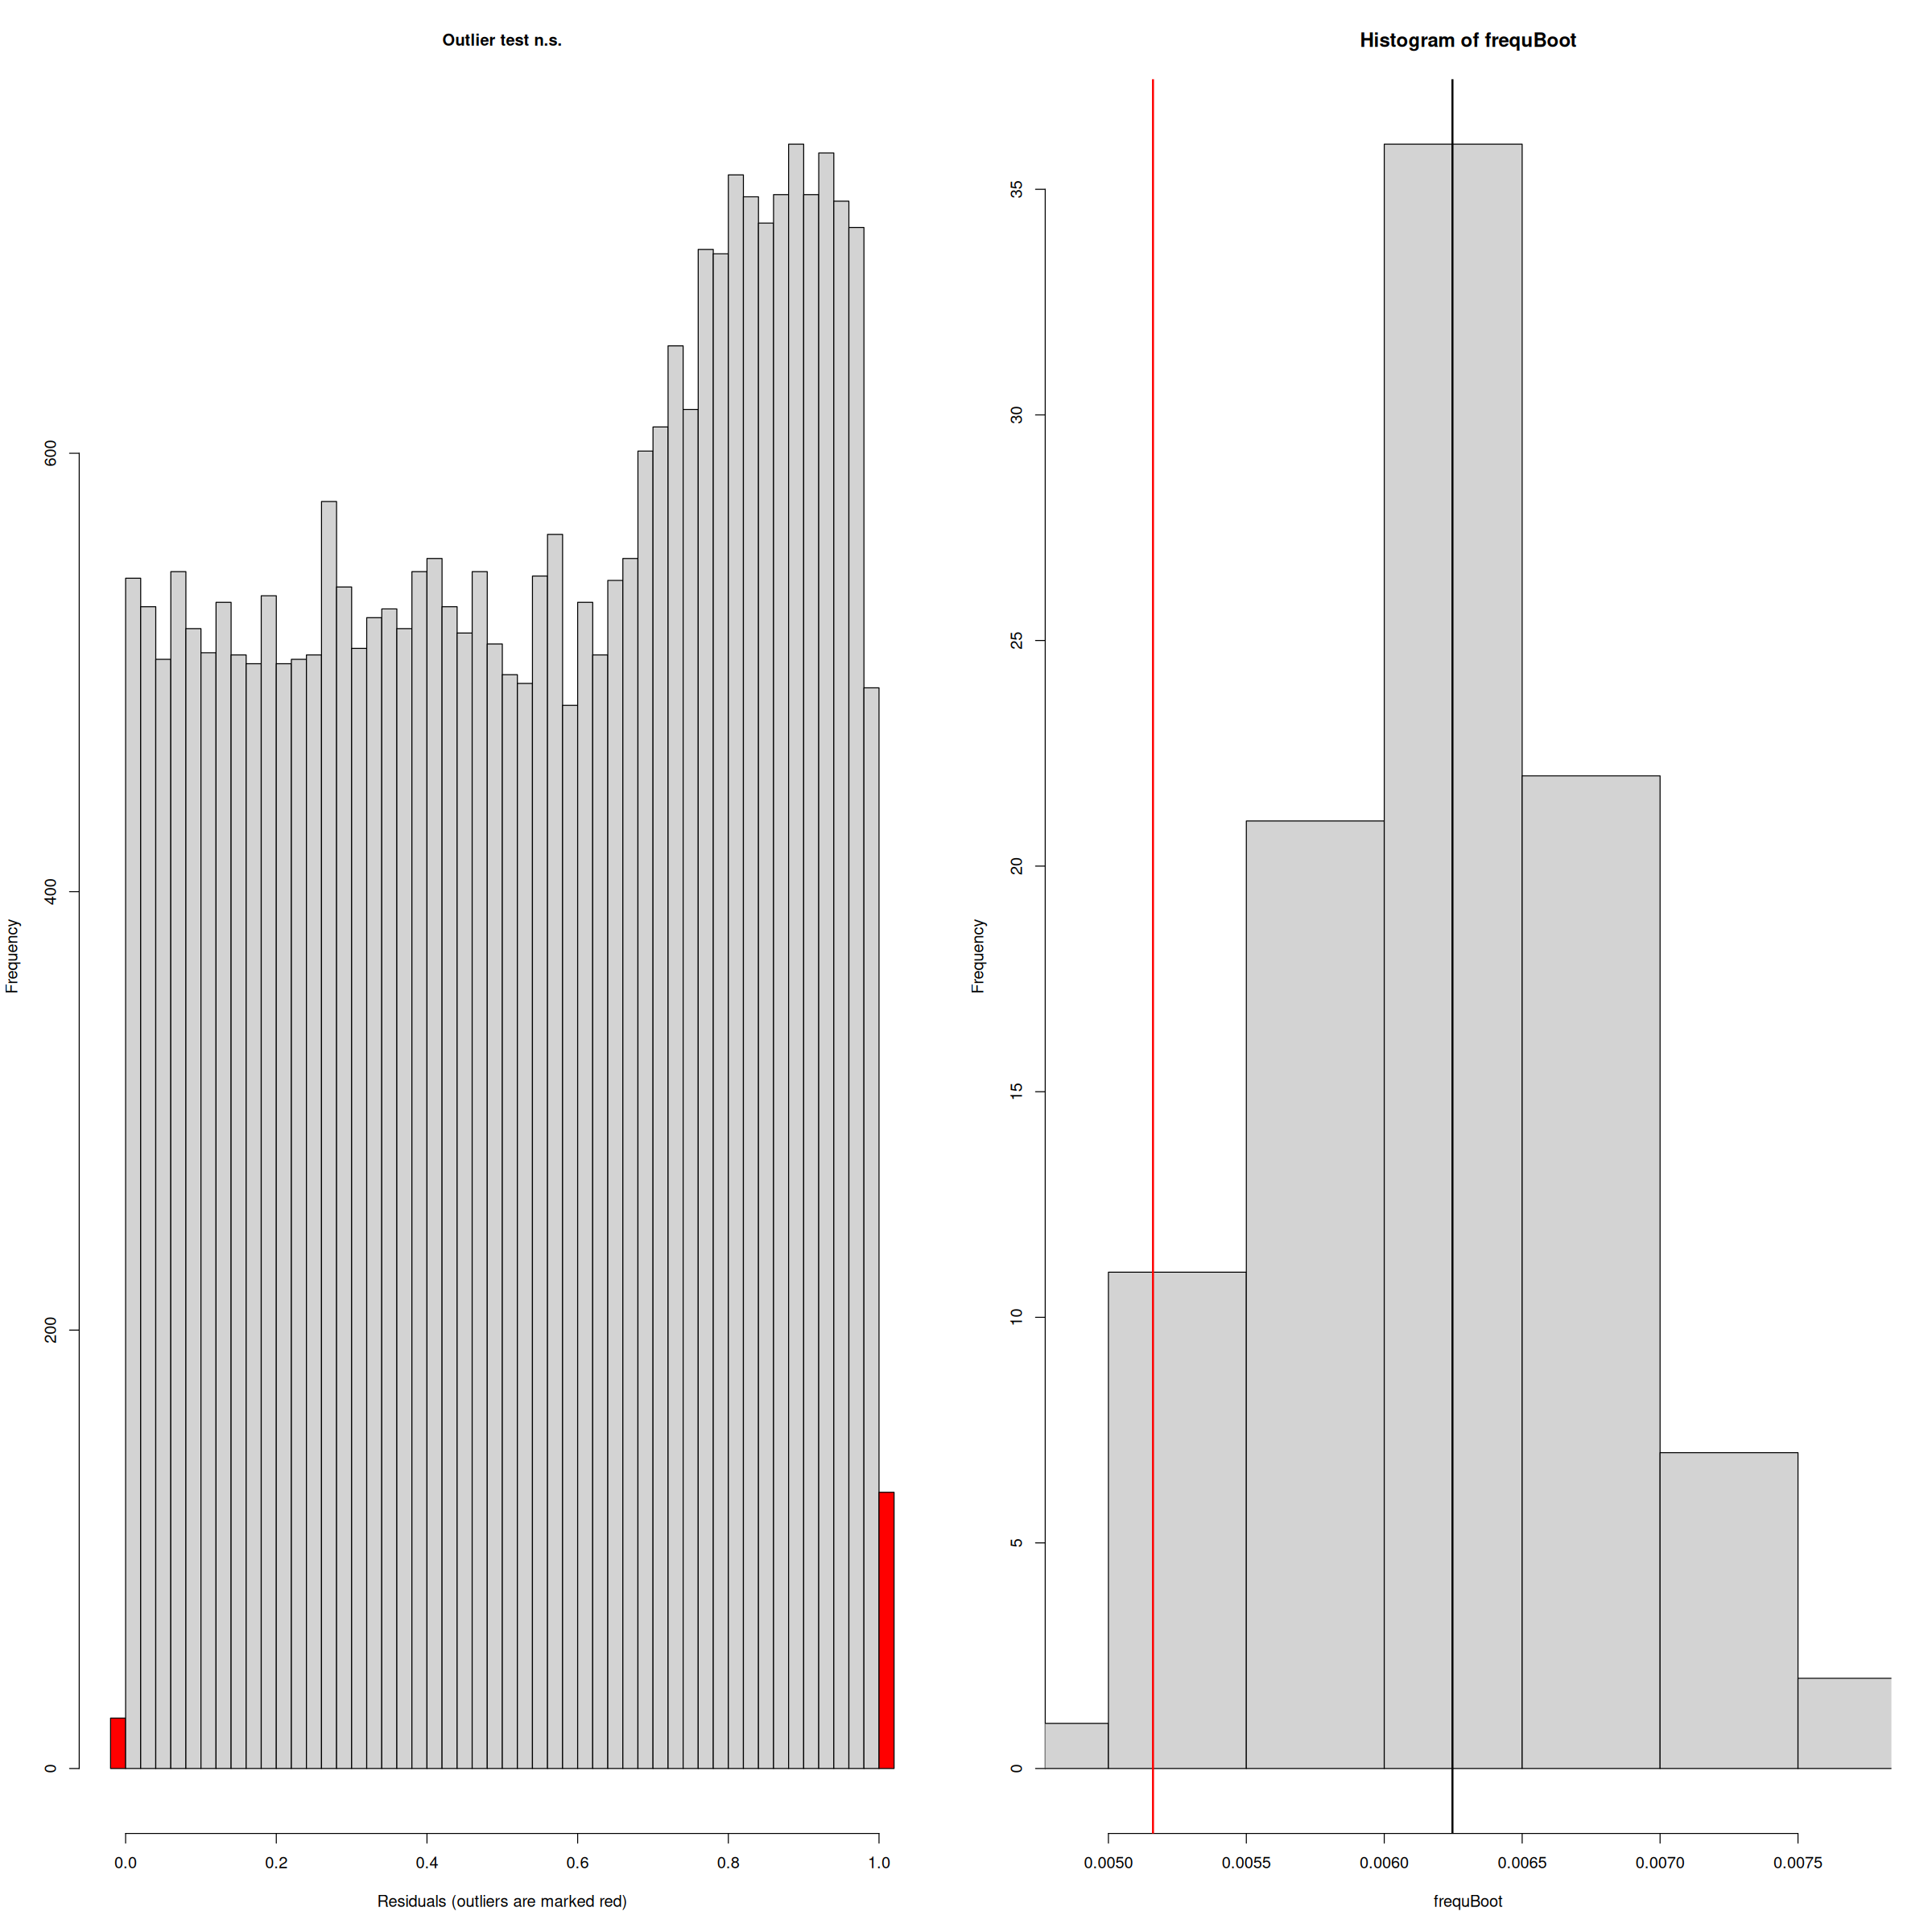

In [24]:
testOutliers(best_model_output, type='bootstrap')

# Replies

## Formula

In [25]:
DV = "t_reply_count_agg"

In [26]:
# Unadjusted formula with only the main interaction
unadjusted_formula_string = paste(DV, " ~ poly(t_polarity, 3)+  + t_subjectivity + a_gender + +t_year + category + (1| a_id)")
unadjusted_formula <- as.formula(unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand"
complete_adjusted_formula_string = paste0(unadjusted_formula_string, adjusted_formula_string)
adjusted_formula <- as.formula(complete_adjusted_formula_string)

# Full interactions formula
full_formula_string <- "+ poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender + poly(t_polarity, 3):t_year + poly(t_polarity, 3):category  + t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category"
complete_full_formula_string <- paste0(unadjusted_formula_string, adjusted_formula_string, full_formula_string)

full_formula <- as.formula(complete_full_formula_string)

## Poisson

### Unadjusted

In [27]:
poisson.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.unadjusted)
check_zeroinflation(poisson.unadjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =     1.640
  Pearson's Chi-Squared = 47318.760
                p-value =   < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 20704
            Ratio: 1.04


### Adjusted

In [28]:
poisson.adjusted <- glmmTMB(adjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.adjusted)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =     1.650
  Pearson's Chi-Squared = 47596.678
                p-value =   < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 20660
            Ratio: 1.04


### Full model

In [29]:
poisson.adjusted_full <- update(poisson.adjusted, full_formula)
check_overdispersion(poisson.adjusted_full)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =     1.570
  Pearson's Chi-Squared = 45267.336
                p-value =   < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 20660
            Ratio: 1.04


## Negative binomial

### Unadjusted model

In [30]:
neg_bin.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "nbinom2")
check_overdispersion(neg_bin.unadjusted)
check_zeroinflation(neg_bin.unadjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.319
  Pearson's Chi-Squared = 9199.893
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 21305
            Ratio: 1.07


### Adjusted model

In [31]:
neg_bin.adjusted <- update(neg_bin.unadjusted, adjusted_formula)
check_overdispersion(neg_bin.adjusted)
check_zeroinflation(neg_bin.adjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.339
  Pearson's Chi-Squared = 9785.779
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 21233
            Ratio: 1.06


## Full model

In [32]:
neg_bin.adjusted_full <- update(neg_bin.adjusted, full_formula)
check_overdispersion(neg_bin.adjusted_full)
check_zeroinflation(neg_bin.adjusted_full)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.339
  Pearson's Chi-Squared = 9766.005
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 19946
  Predicted zeros: 21232
            Ratio: 1.06


## Anova

In [33]:
anova(neg_bin.unadjusted, neg_bin.adjusted, neg_bin.adjusted_full)

Df AIC      BIC      logLik    deviance Chisq      Chi Df
neg_bin.unadjusted    10 69520.20 69602.91 -34750.10 69500.20         NA NA    
neg_bin.adjusted      14 68454.44 68570.22 -34213.22 68426.44 1073.76797  4    
neg_bin.adjusted_full 29 68457.10 68696.94 -34199.55 68399.10   27.33489 15    
                      Pr(>Chisq)   
neg_bin.unadjusted               NA
neg_bin.adjusted      3.672284e-231
neg_bin.adjusted_full  2.612335e-02

## Best model

In [34]:
best_model <- neg_bin.adjusted_full

In [35]:
summary(best_model)

 Family: nbinom2  ( log )
Formula:          
t_reply_count_agg ~ poly(t_polarity, 3) + t_subjectivity + a_gender +  
    t_year + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + a_listed_count_stand +  
    poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender +  
    poly(t_polarity, 3):t_year + poly(t_polarity, 3):category +  
    t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
 68457.1  68696.9 -34199.6  68399.1    28838 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 3.186    1.785   
Number of obs: 28867, groups:  a_id, 22973

Dispersion parameter for nbinom2 family (): 1.45 

Conditional model:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -1.94249    0.05790  -33.55  < 2e-16
poly(t_polarity, 3)1                

In [36]:
# Generate effects
# Use allEffects to compute and display all main effects
effects_output <- allEffects(best_model)

Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Eff

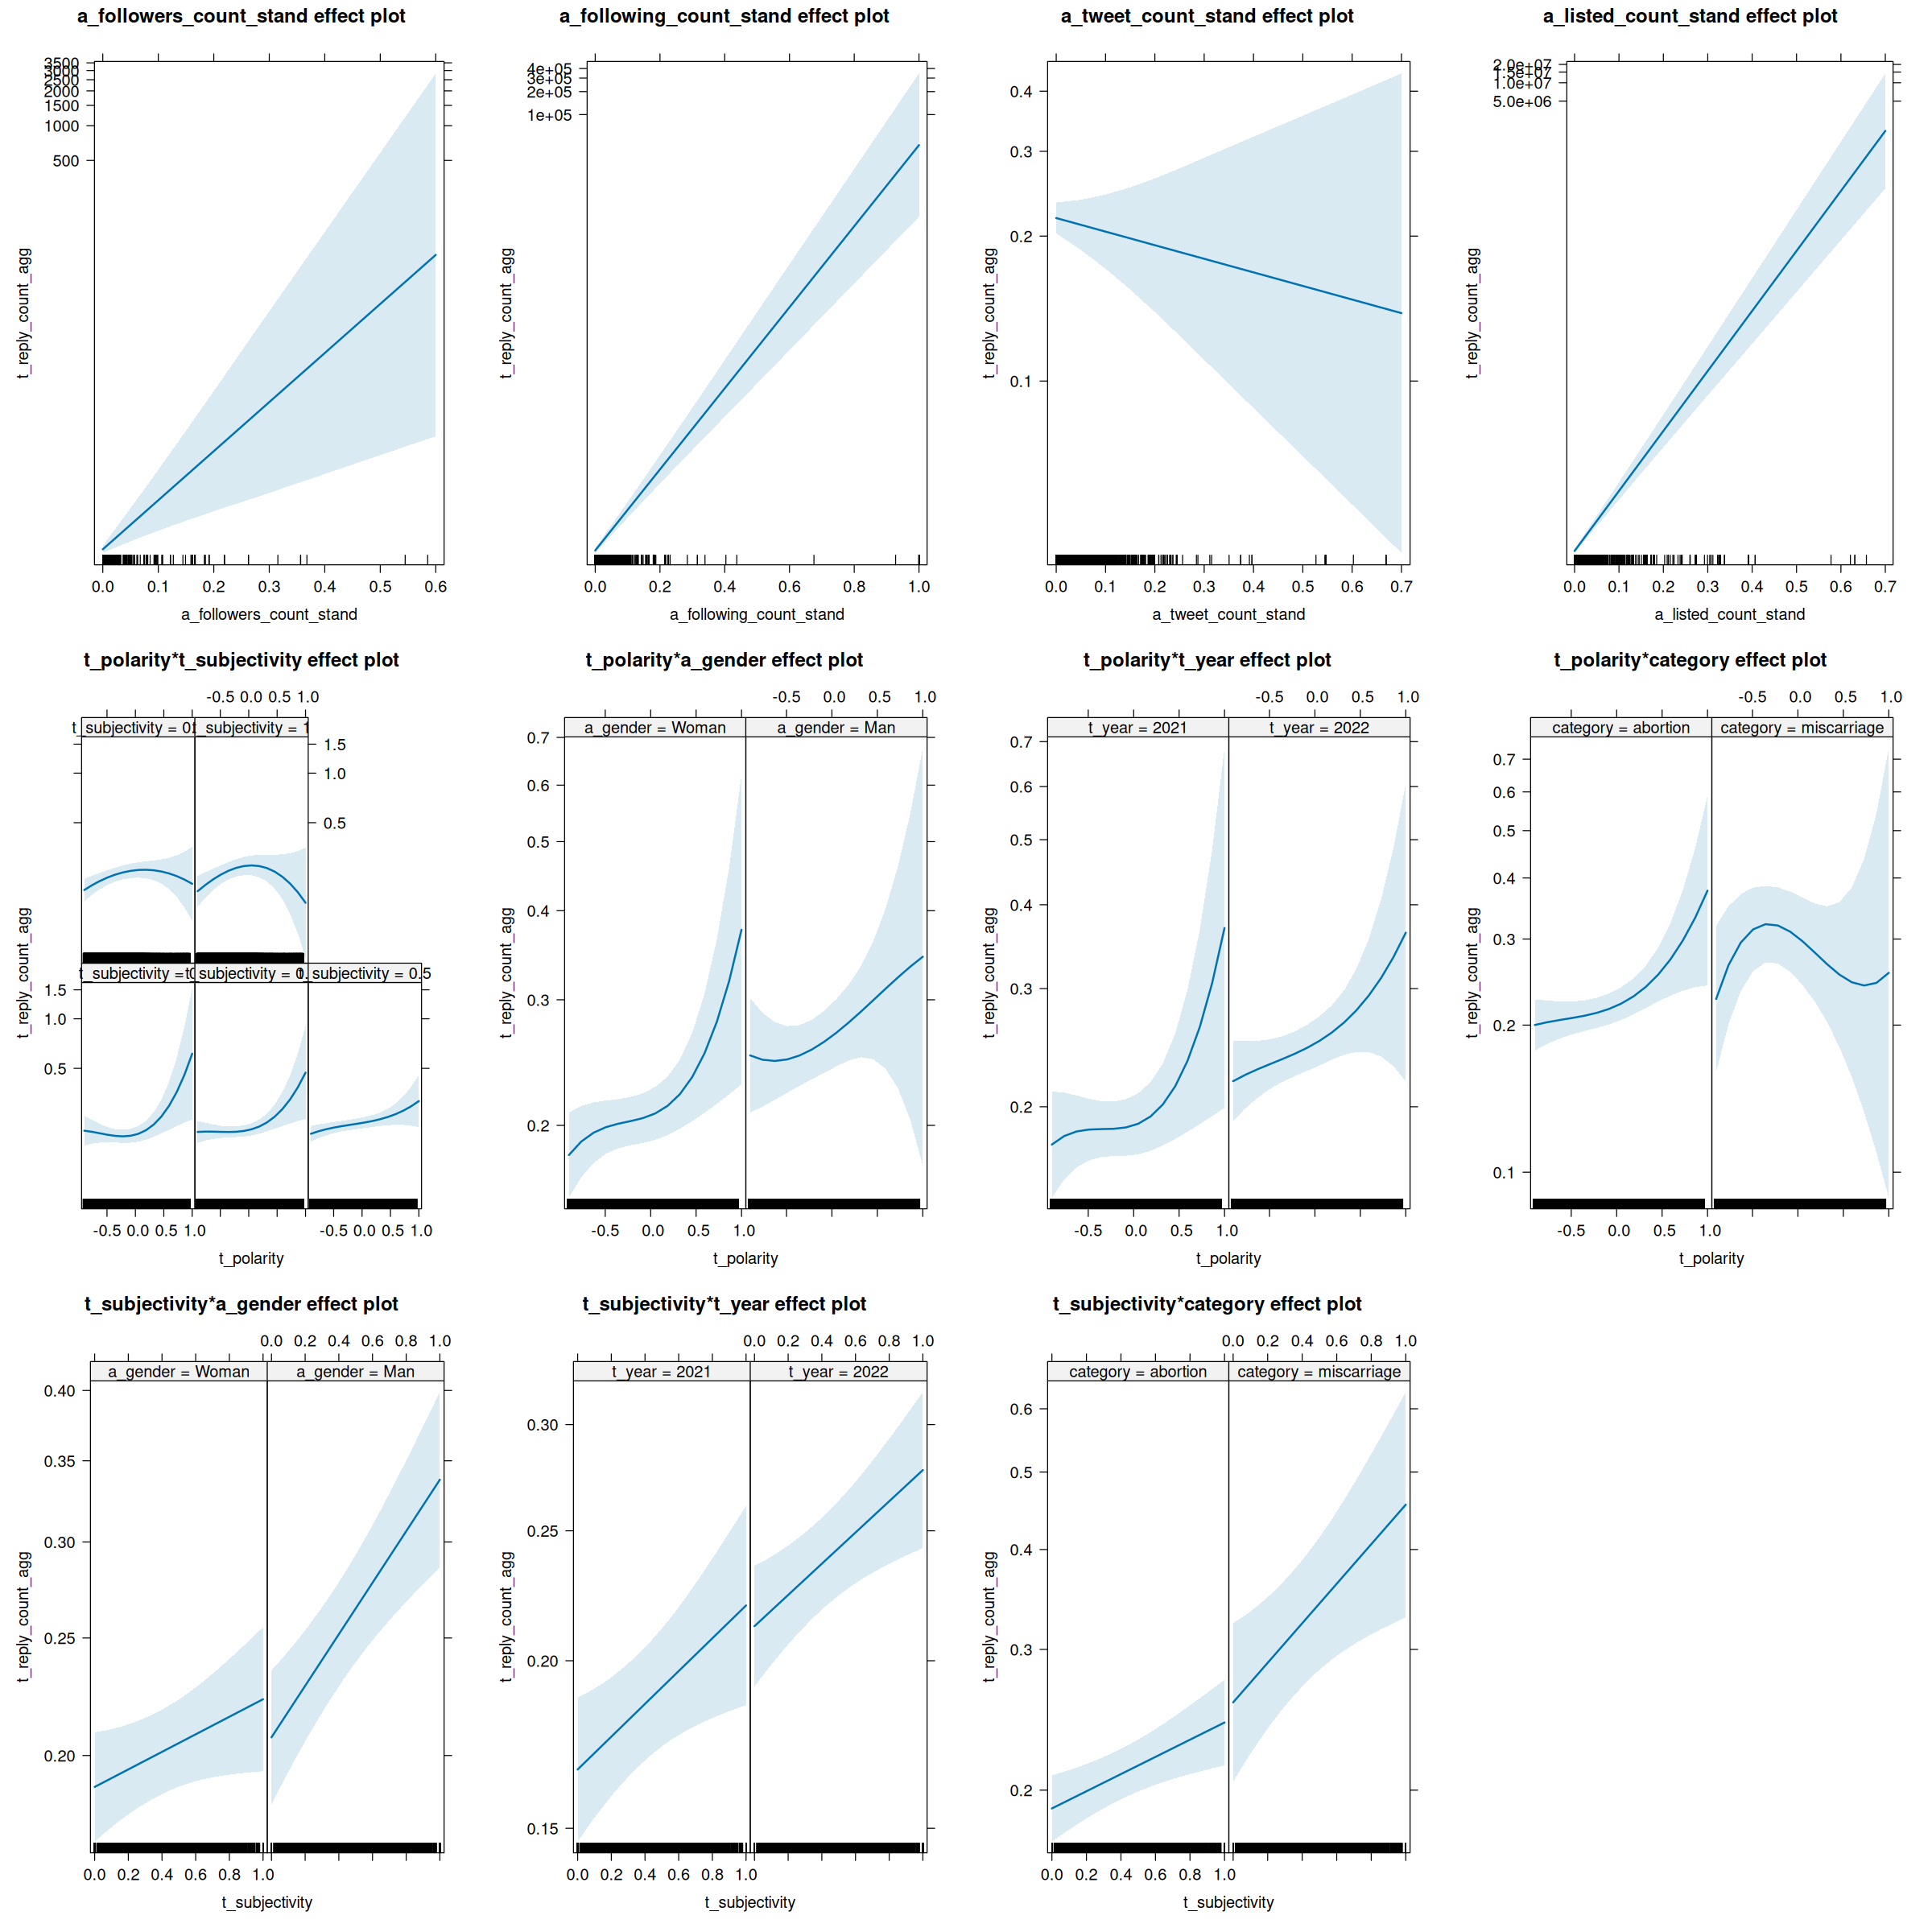

In [37]:
options(repr.plot.width=20, repr.plot.height=20)
plot(effects_output)

In [38]:
best_model_output <- simulateResiduals(fittedModel = best_model)

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



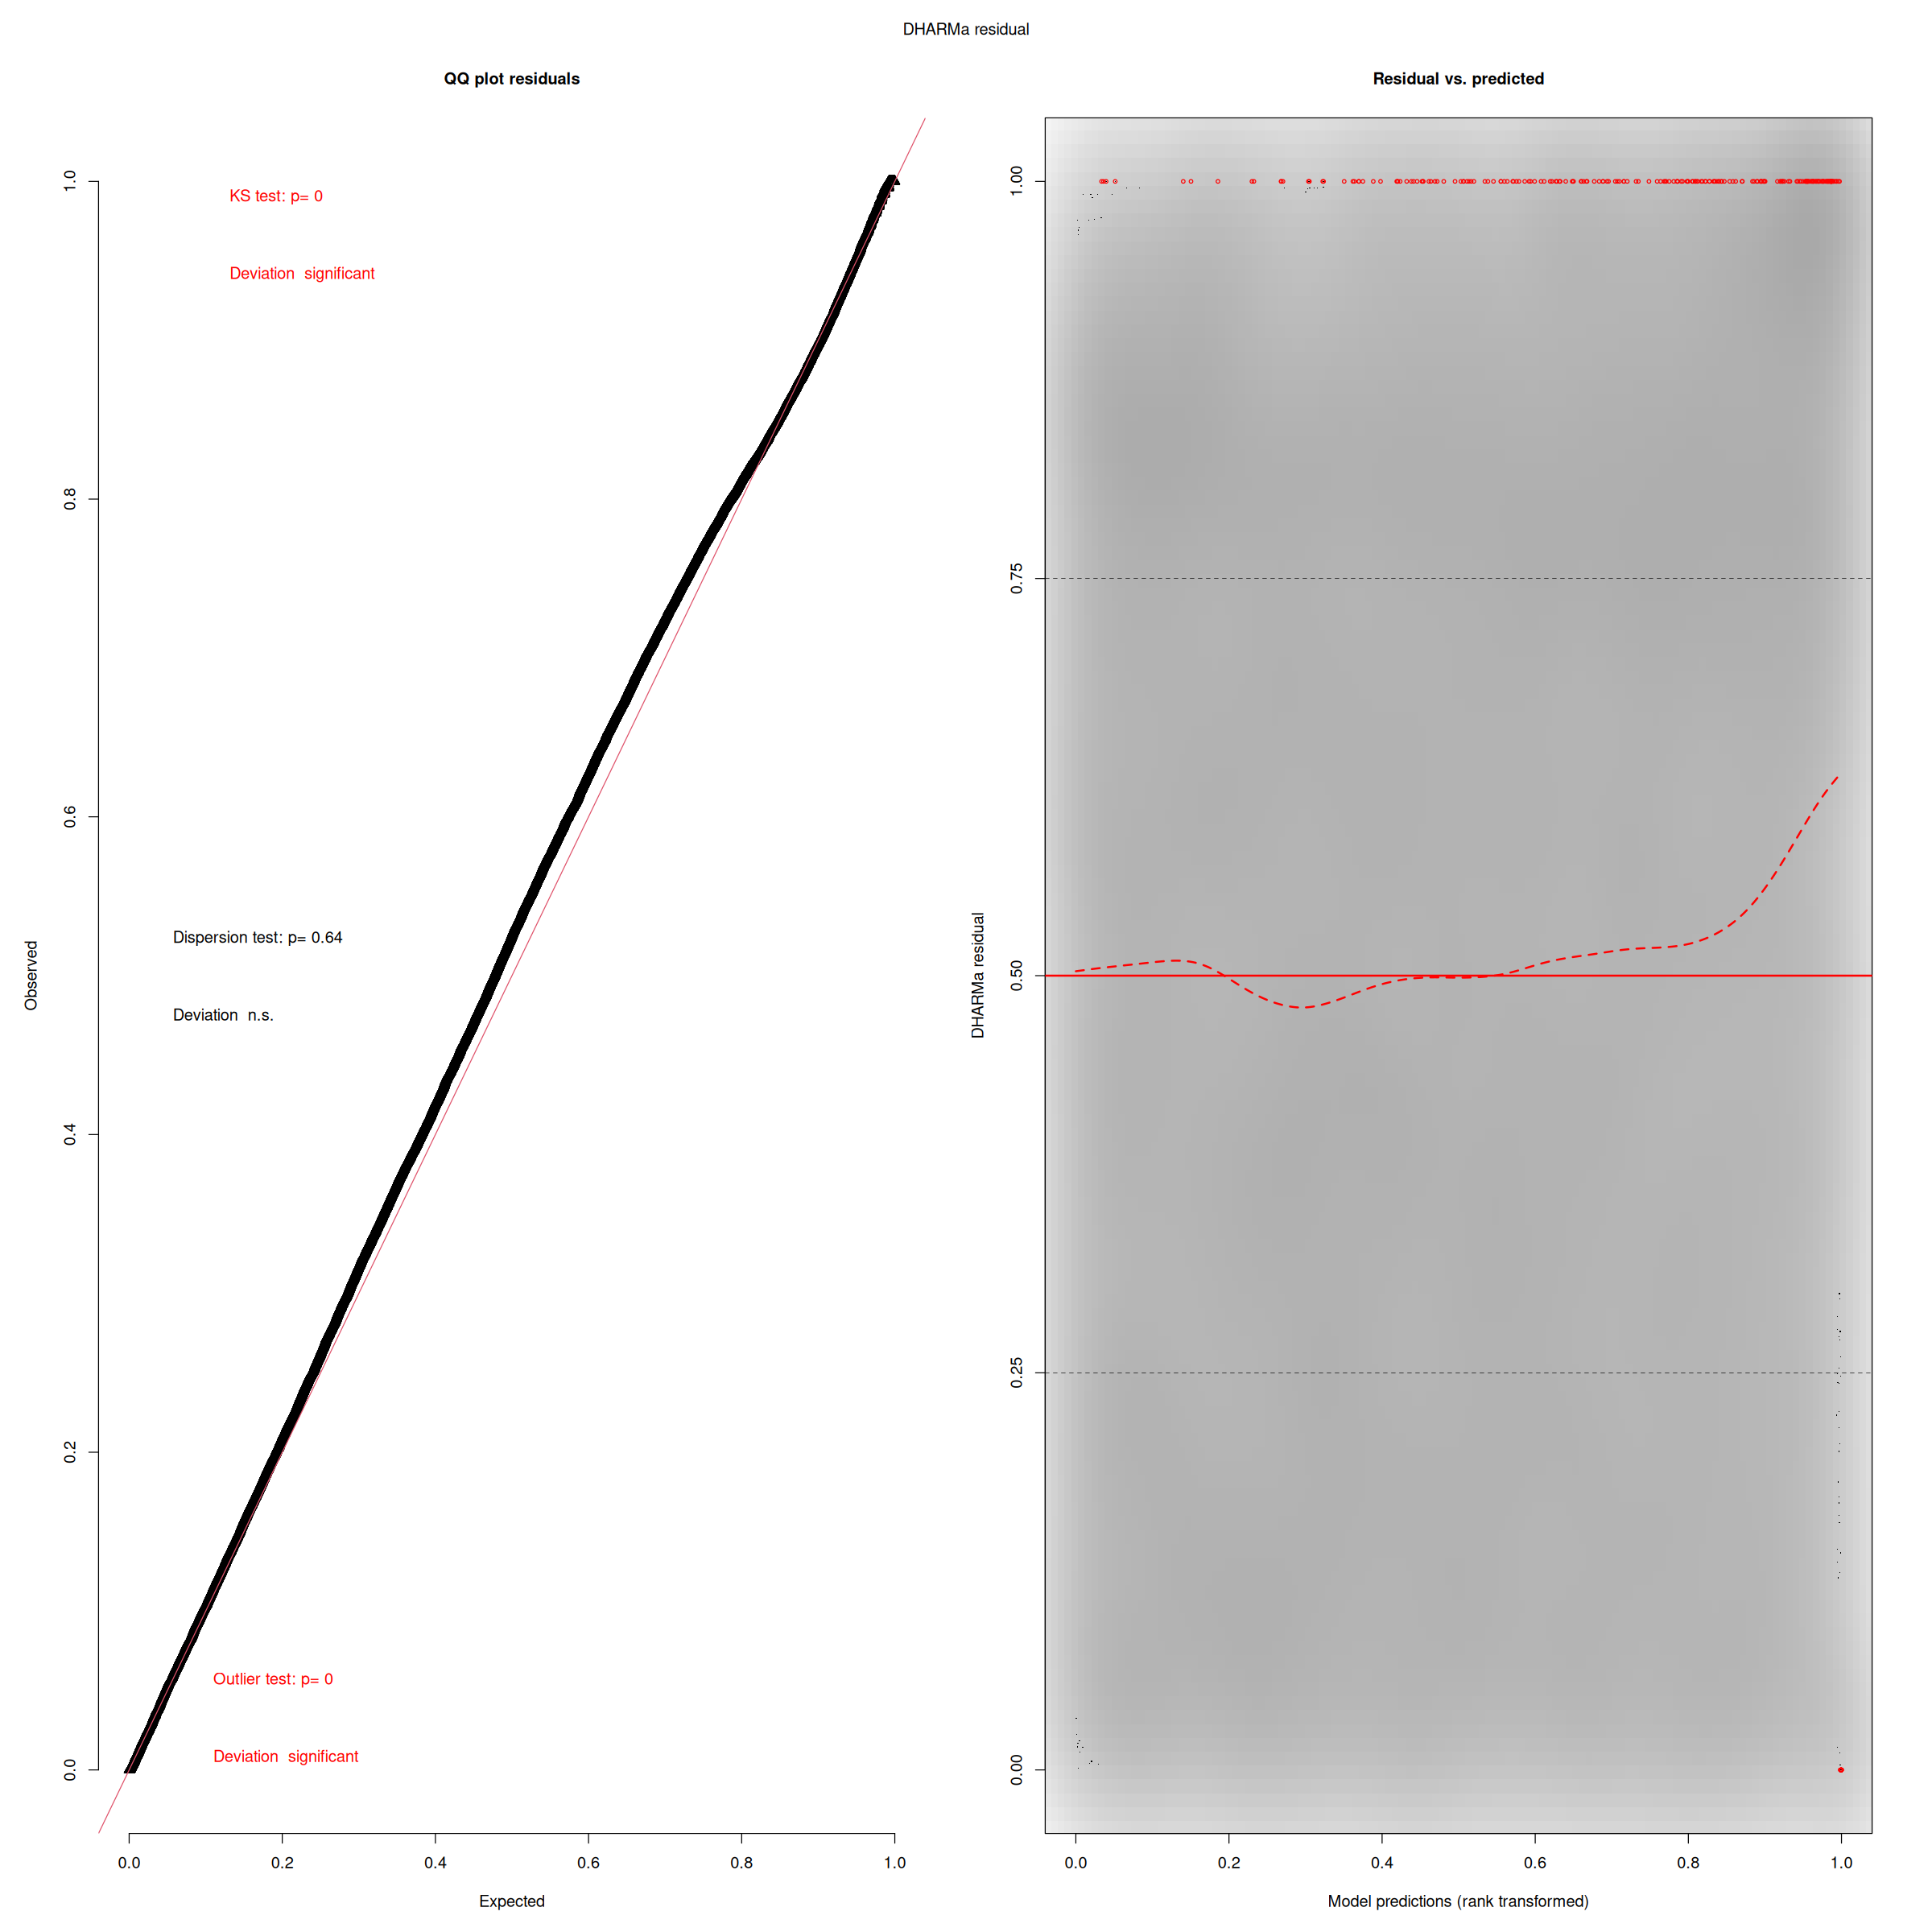

In [39]:
plot(best_model_output)


	DHARMa bootstrapped outlier test

data:  best_model_output
outliers at both margin(s) = 248, observations = 28867, p-value <
2.2e-16
alternative hypothesis: two.sided
 percent confidence interval:
 0.004986663 0.007052170
sample estimates:
outlier frequency (expected: 0.00603180101846399 ) 
                                       0.008591125 


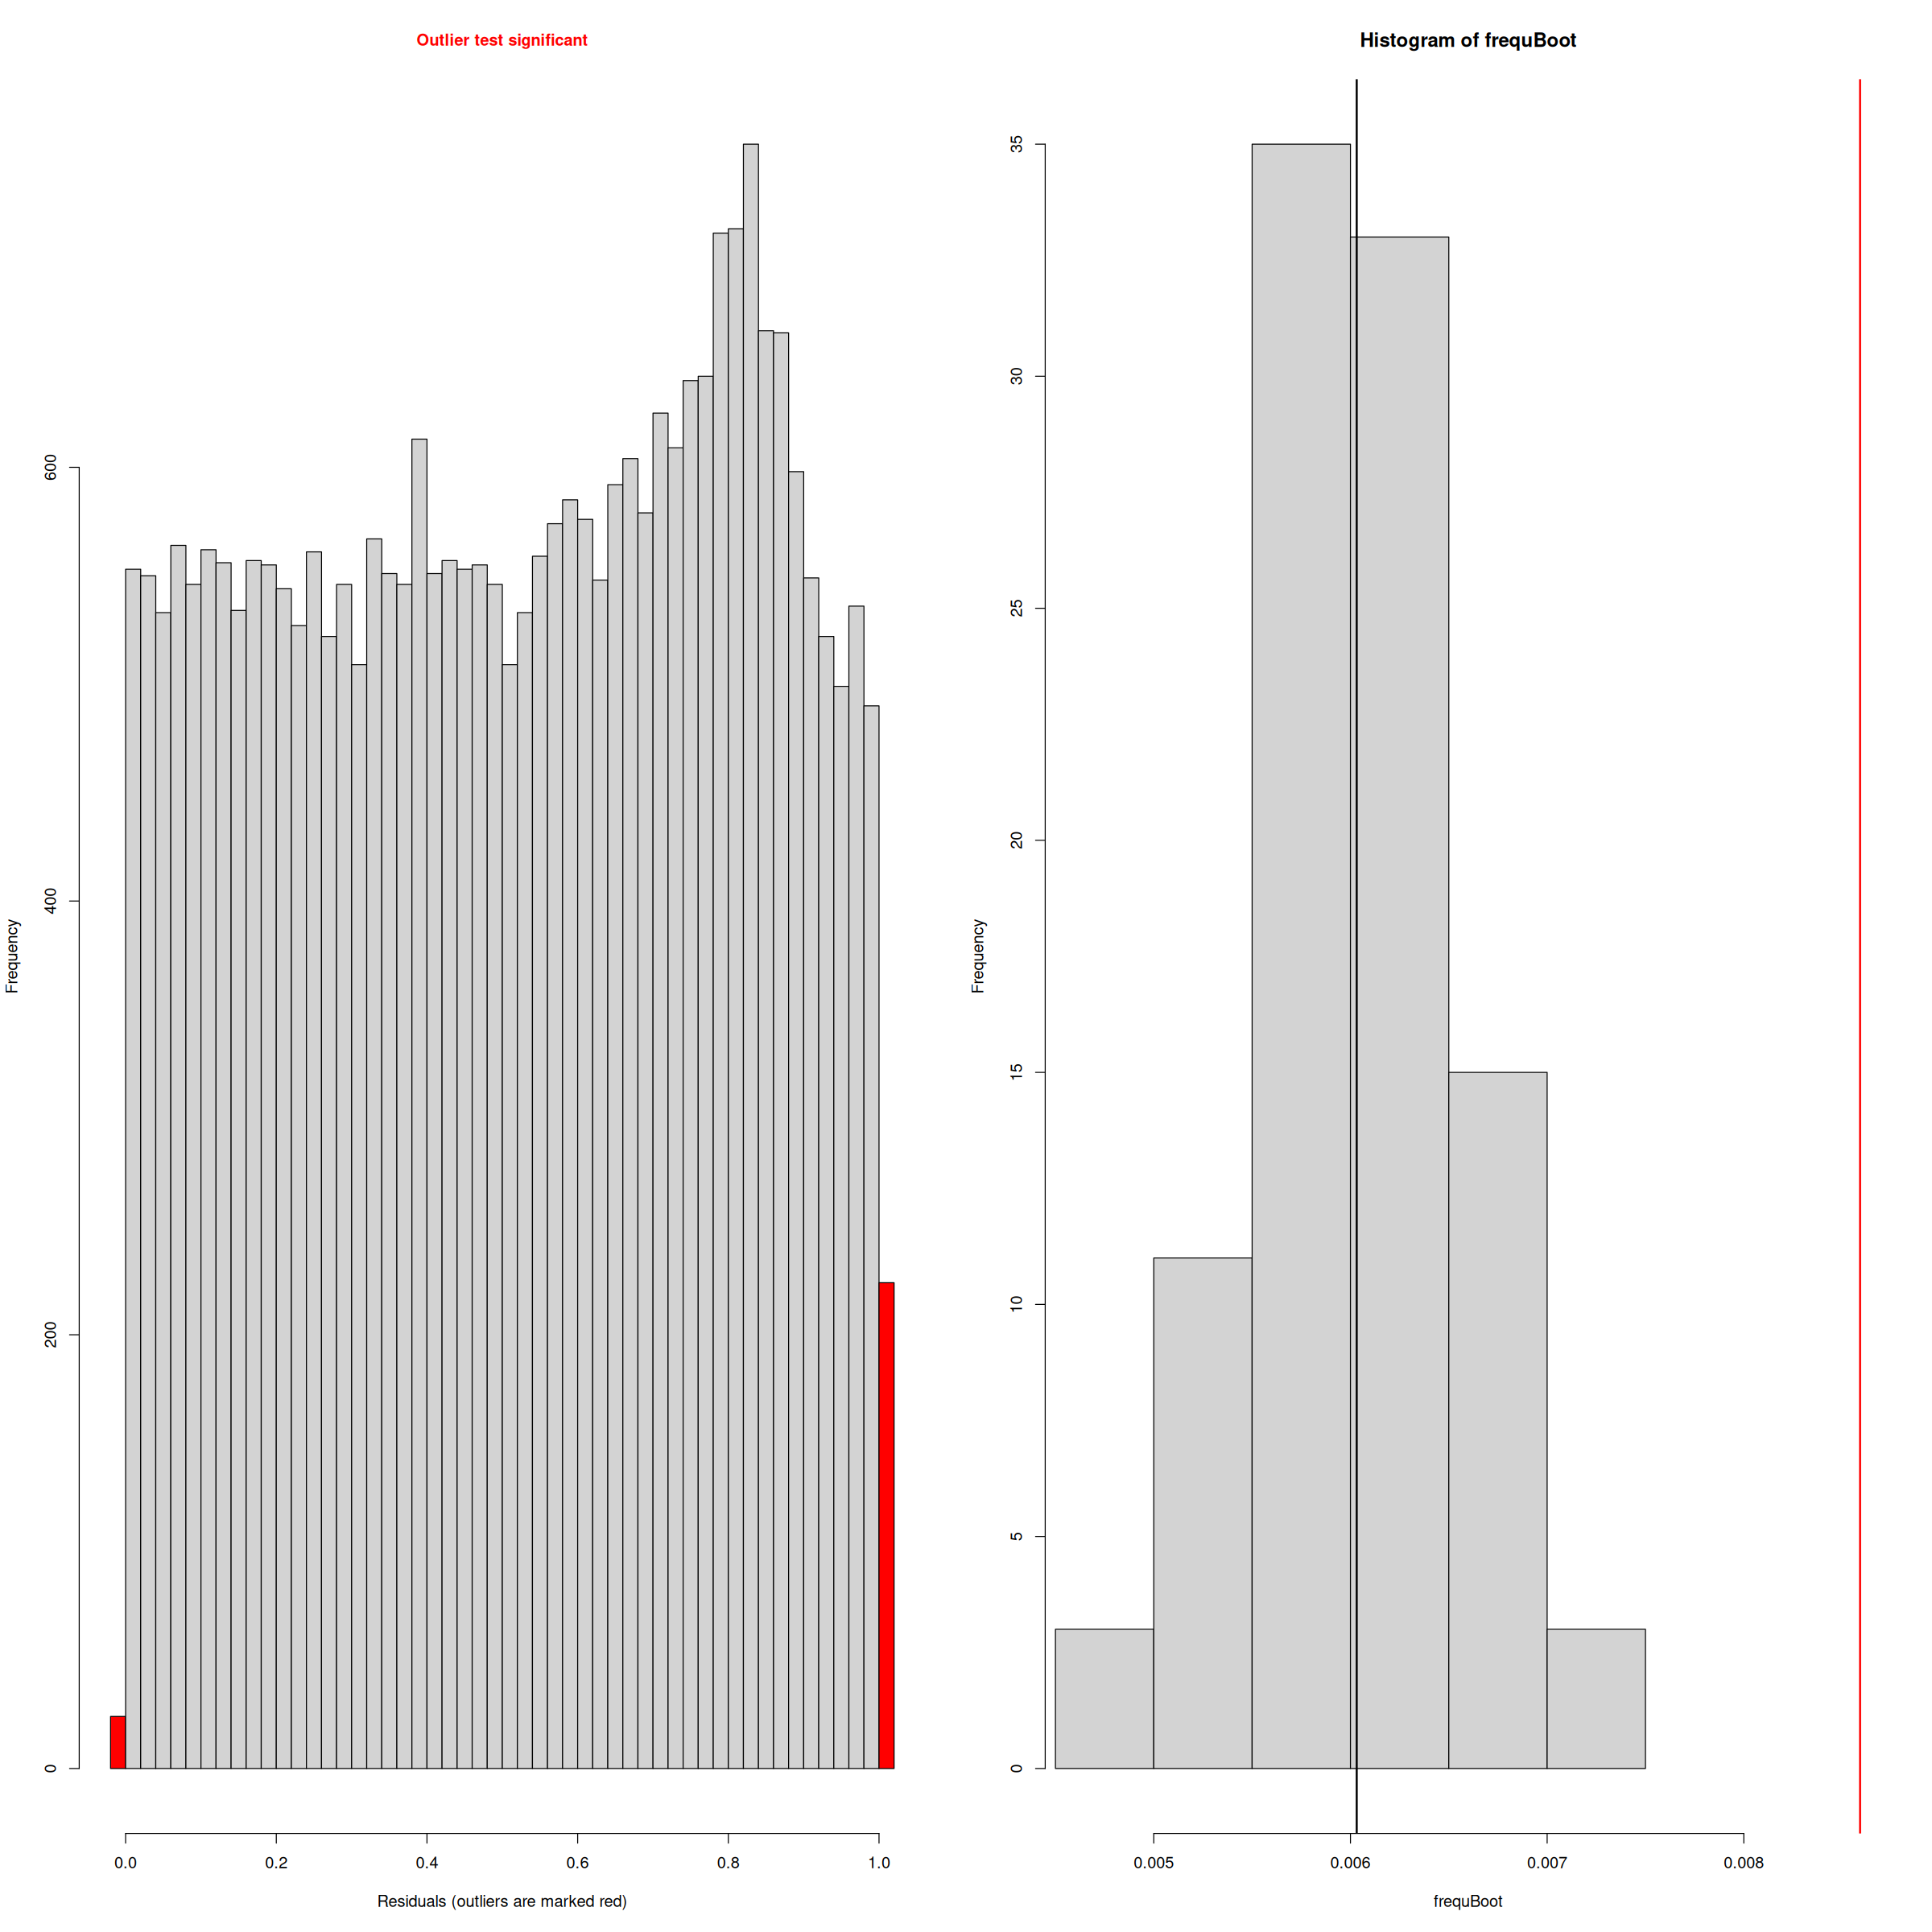

In [40]:
testOutliers(best_model_output, type='bootstrap')

# Likes

## Formula

In [41]:
DV = "t_retweet_count_agg"

In [42]:
# Unadjusted formula with only the main interaction
unadjusted_formula_string = paste(DV, " ~ poly(t_polarity, 3)+  + t_subjectivity + a_gender + +t_year + category + (1| a_id)")
unadjusted_formula <- as.formula(unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand"
complete_adjusted_formula_string = paste0(unadjusted_formula_string, adjusted_formula_string)
adjusted_formula <- as.formula(complete_adjusted_formula_string)

# Full interactions formula
full_formula_string <- "+ poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender + poly(t_polarity, 3):t_year + poly(t_polarity, 3):category  + t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category"
complete_full_formula_string <- paste0(unadjusted_formula_string, adjusted_formula_string, full_formula_string)

full_formula <- as.formula(complete_full_formula_string)

## Poisson

### Unadjusted

In [43]:
poisson.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.unadjusted)
check_zeroinflation(poisson.unadjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      6.089
  Pearson's Chi-Squared = 175726.827
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19308
            Ratio: 1.03


### Adjusted

In [44]:
poisson.adjusted <- glmmTMB(adjusted_formula, data=df, family = "poisson")
check_overdispersion(poisson.adjusted)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      6.093
  Pearson's Chi-Squared = 175800.681
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19245
            Ratio: 1.02


### Full model

In [45]:
poisson.adjusted_full <- update(poisson.adjusted, full_formula)
check_overdispersion(poisson.adjusted_full)
check_zeroinflation(poisson.adjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      5.693
  Pearson's Chi-Squared = 164185.420
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 19245
            Ratio: 1.02


## Negative binomial

### Unadjusted model

In [46]:
neg_bin.unadjusted <- glmmTMB(unadjusted_formula, data=df, family = "nbinom2")
check_overdispersion(neg_bin.unadjusted)
check_zeroinflation(neg_bin.unadjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.264
  Pearson's Chi-Squared = 7608.738
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 20221
            Ratio: 1.07


### Adjusted model

In [47]:
neg_bin.adjusted <- update(neg_bin.unadjusted, adjusted_formula)
check_overdispersion(neg_bin.adjusted)
check_zeroinflation(neg_bin.adjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.273
  Pearson's Chi-Squared = 7886.553
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 20129
            Ratio: 1.07


## Full model

In [48]:
neg_bin.adjusted_full <- update(neg_bin.adjusted, full_formula)
check_overdispersion(neg_bin.adjusted_full)
check_zeroinflation(neg_bin.adjusted_full)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.274
  Pearson's Chi-Squared = 7890.664
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 18826
  Predicted zeros: 20123
            Ratio: 1.07


## Anova

In [49]:
anova(neg_bin.unadjusted, neg_bin.adjusted, neg_bin.adjusted_full)

Df AIC      BIC      logLik    deviance Chisq      Chi Df
neg_bin.unadjusted    10 93613.17 93695.87 -46796.58 93593.17         NA NA    
neg_bin.adjusted      14 92314.75 92430.54 -46143.38 92286.75 1306.41537  4    
neg_bin.adjusted_full 29 92306.31 92546.15 -46124.15 92248.31   38.44618 15    
                      Pr(>Chisq)   
neg_bin.unadjusted               NA
neg_bin.adjusted      1.352766e-281
neg_bin.adjusted_full  7.749108e-04

## Best model

In [50]:
best_model <- neg_bin.adjusted_full

In [51]:
summary(best_model)

 Family: nbinom2  ( log )
Formula:          t_retweet_count_agg ~ poly(t_polarity, 3) + t_subjectivity +  
    a_gender + t_year + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + a_listed_count_stand +  
    poly(t_polarity, 3):t_subjectivity + poly(t_polarity, 3):a_gender +  
    poly(t_polarity, 3):t_year + poly(t_polarity, 3):category +  
    t_subjectivity:a_gender + t_subjectivity:t_year + t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
 92306.3  92546.1 -46124.2  92248.3    28838 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.744    2.783   
Number of obs: 28867, groups:  a_id, 22973

Dispersion parameter for nbinom2 family (): 1.23 

Conditional model:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -2.52359    0.07384  -34.18  < 2e-16
poly(t_polarity, 3)1               

In [52]:
# Generate effects
# Use allEffects to compute and display all main effects
effects_output <- allEffects(best_model)

Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Effect.glmmTMB(predictors, mod, vcov. = vcov., ...):
“overriding variance function for effects/dev.resids: computed variances may be incorrect”
Warning message in Eff

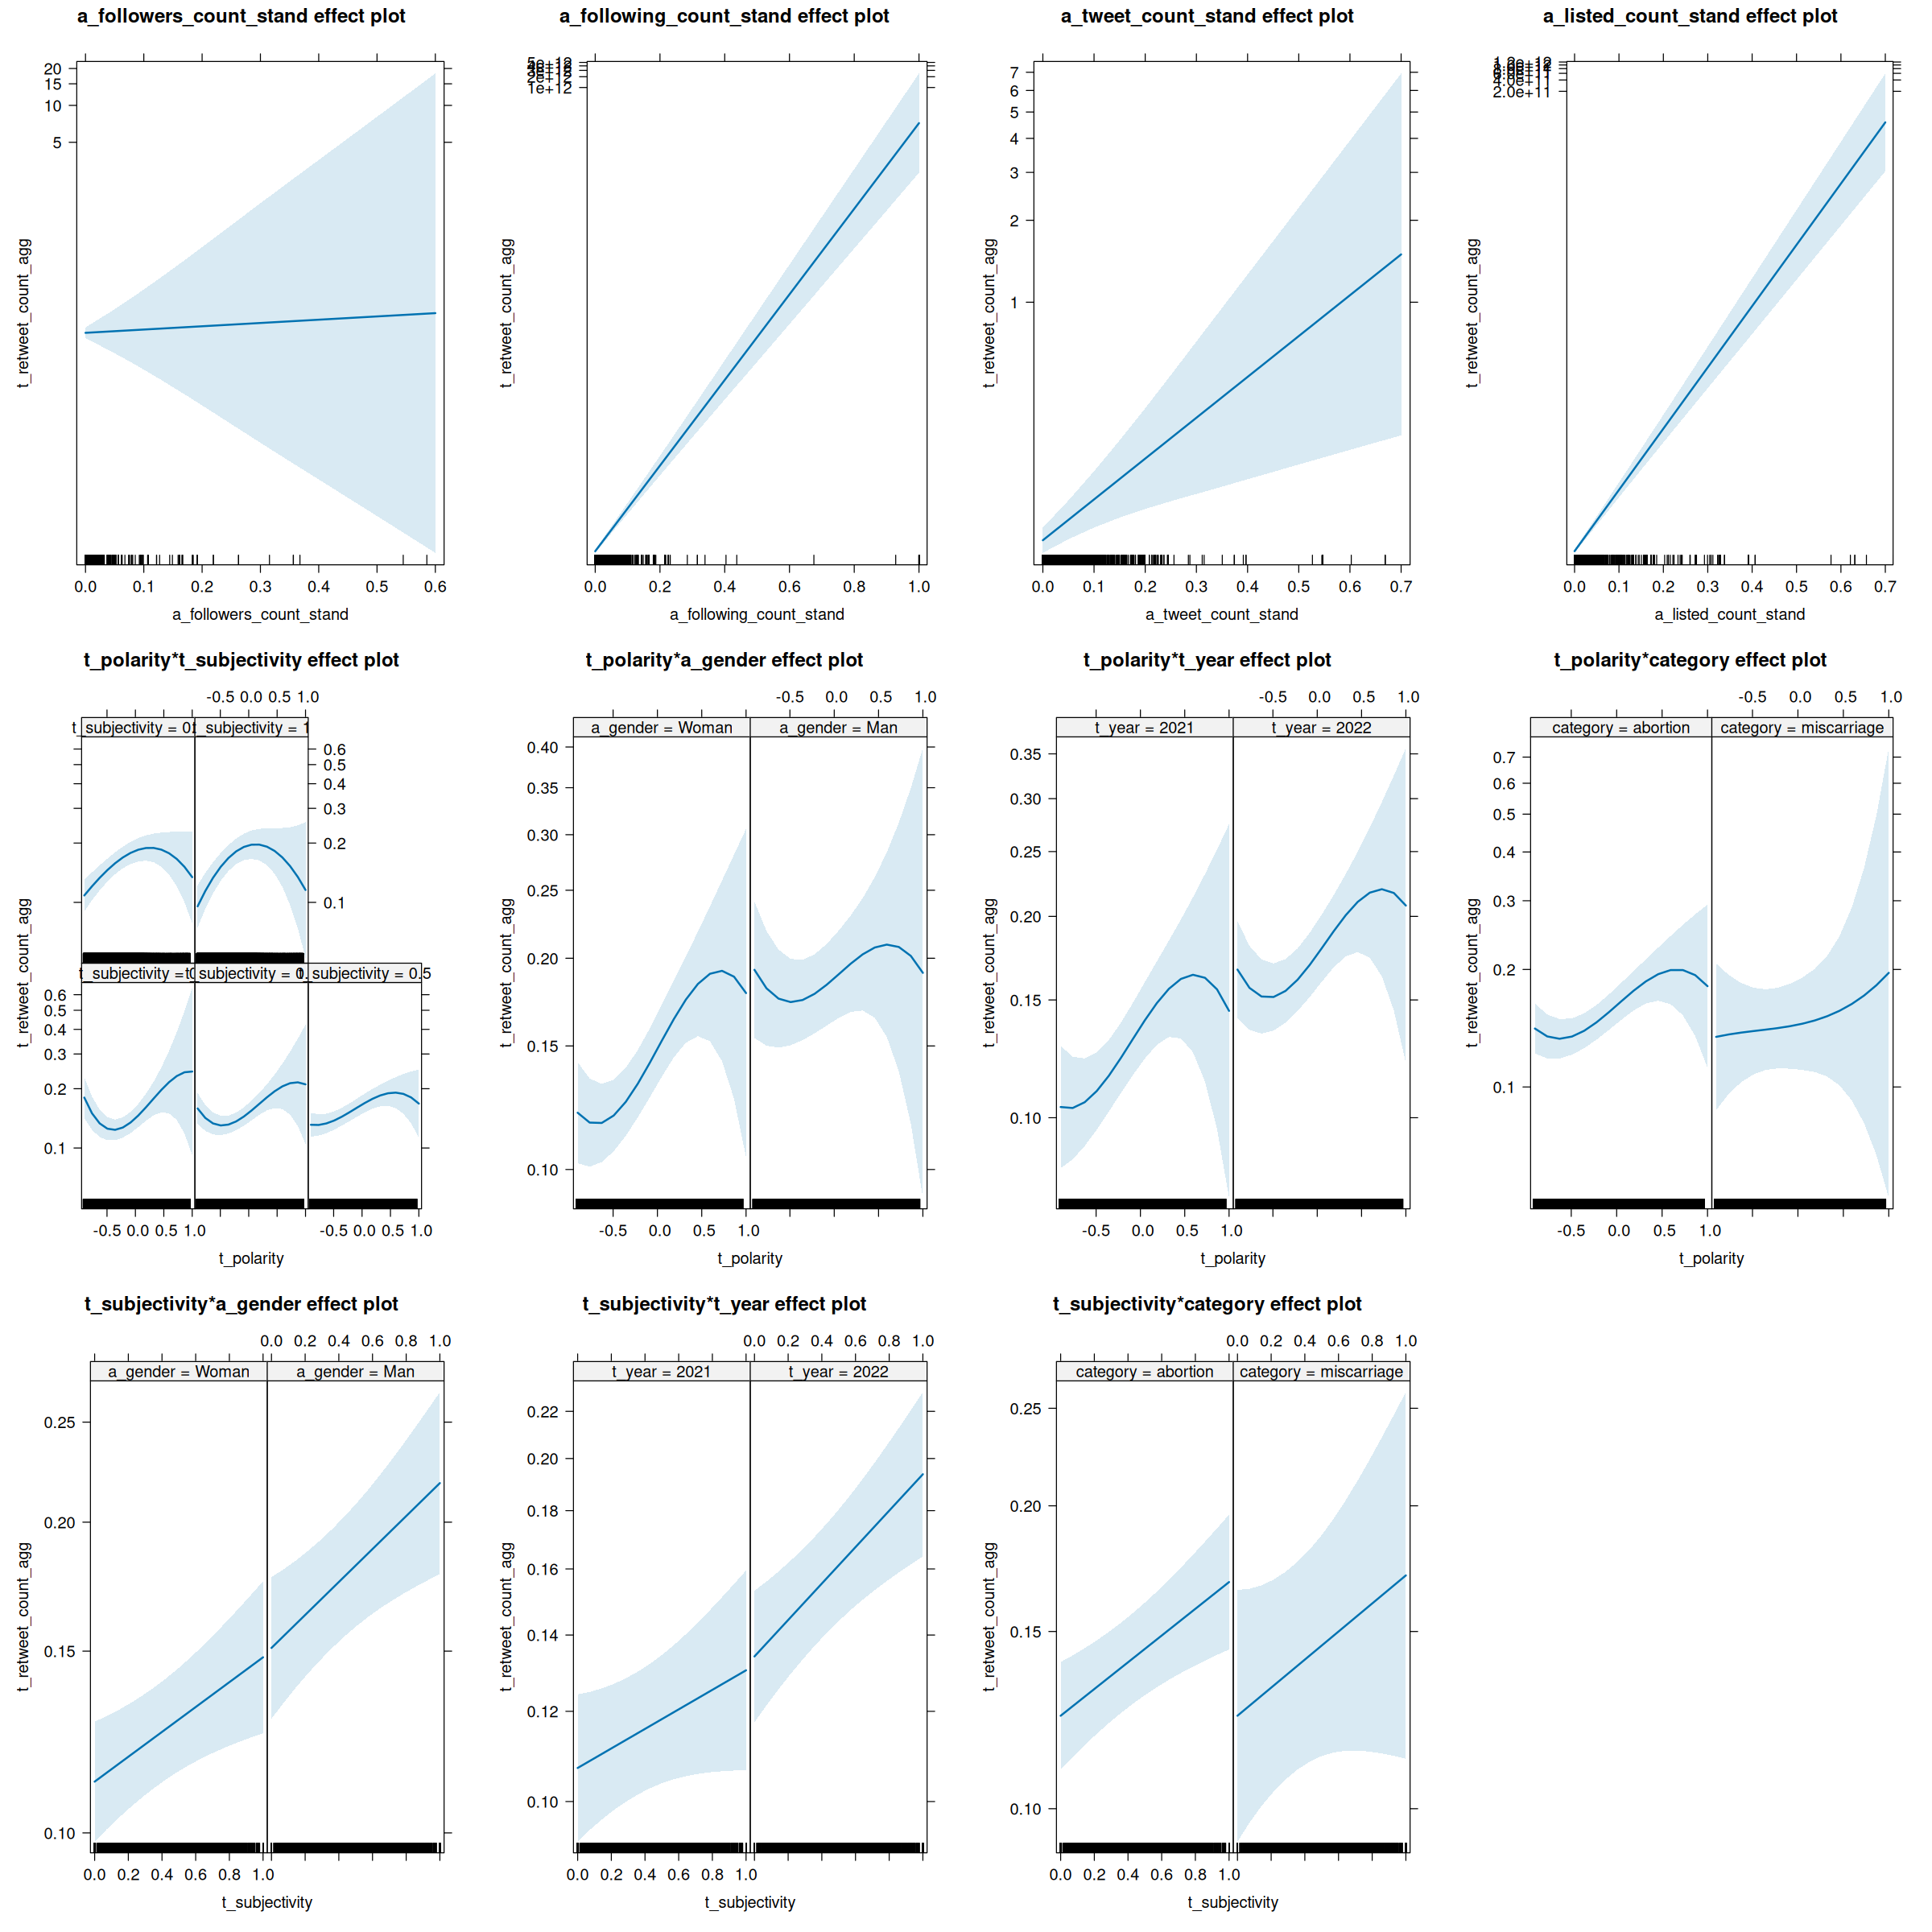

In [53]:
options(repr.plot.width=20, repr.plot.height=20)
plot(effects_output)

In [54]:
best_model_output <- simulateResiduals(fittedModel = best_model)

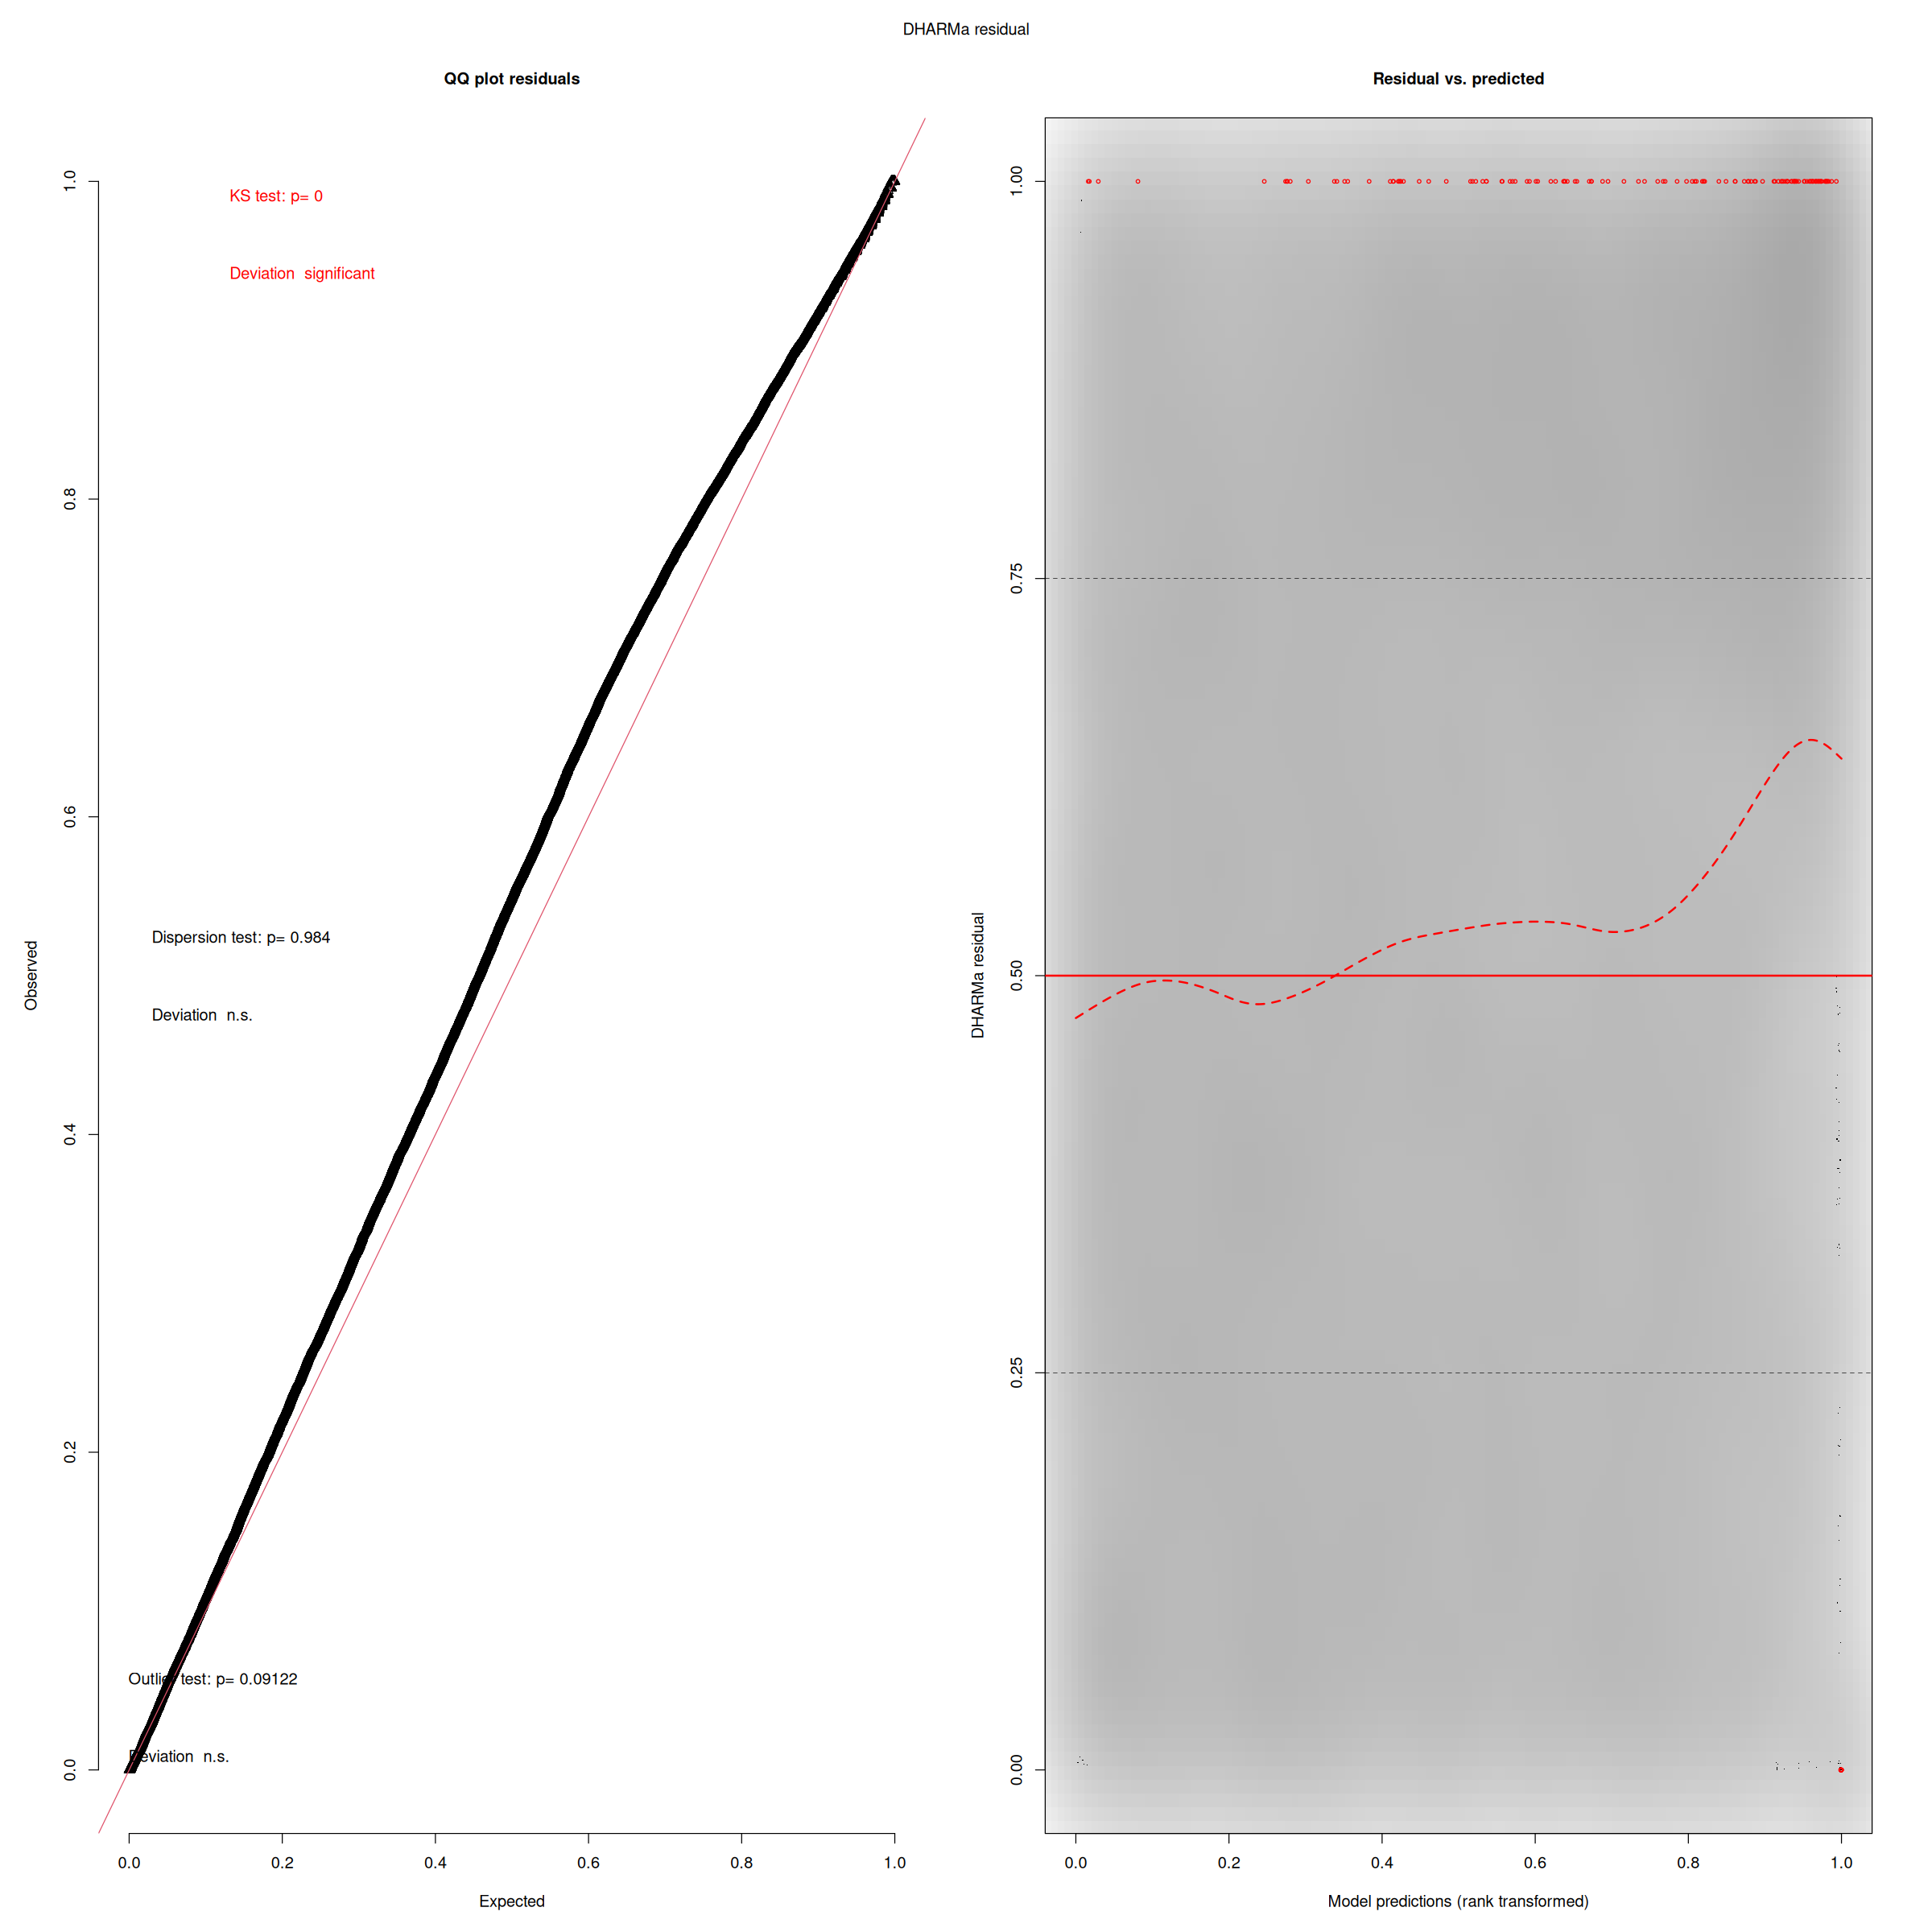

In [55]:
plot(best_model_output)


	DHARMa bootstrapped outlier test

data:  best_model_output
outliers at both margin(s) = 149, observations = 28867, p-value = 0.06
alternative hypothesis: two.sided
 percent confidence interval:
 0.005159871 0.007327571
sample estimates:
outlier frequency (expected: 0.00625212179997922 ) 
                                       0.005161603 


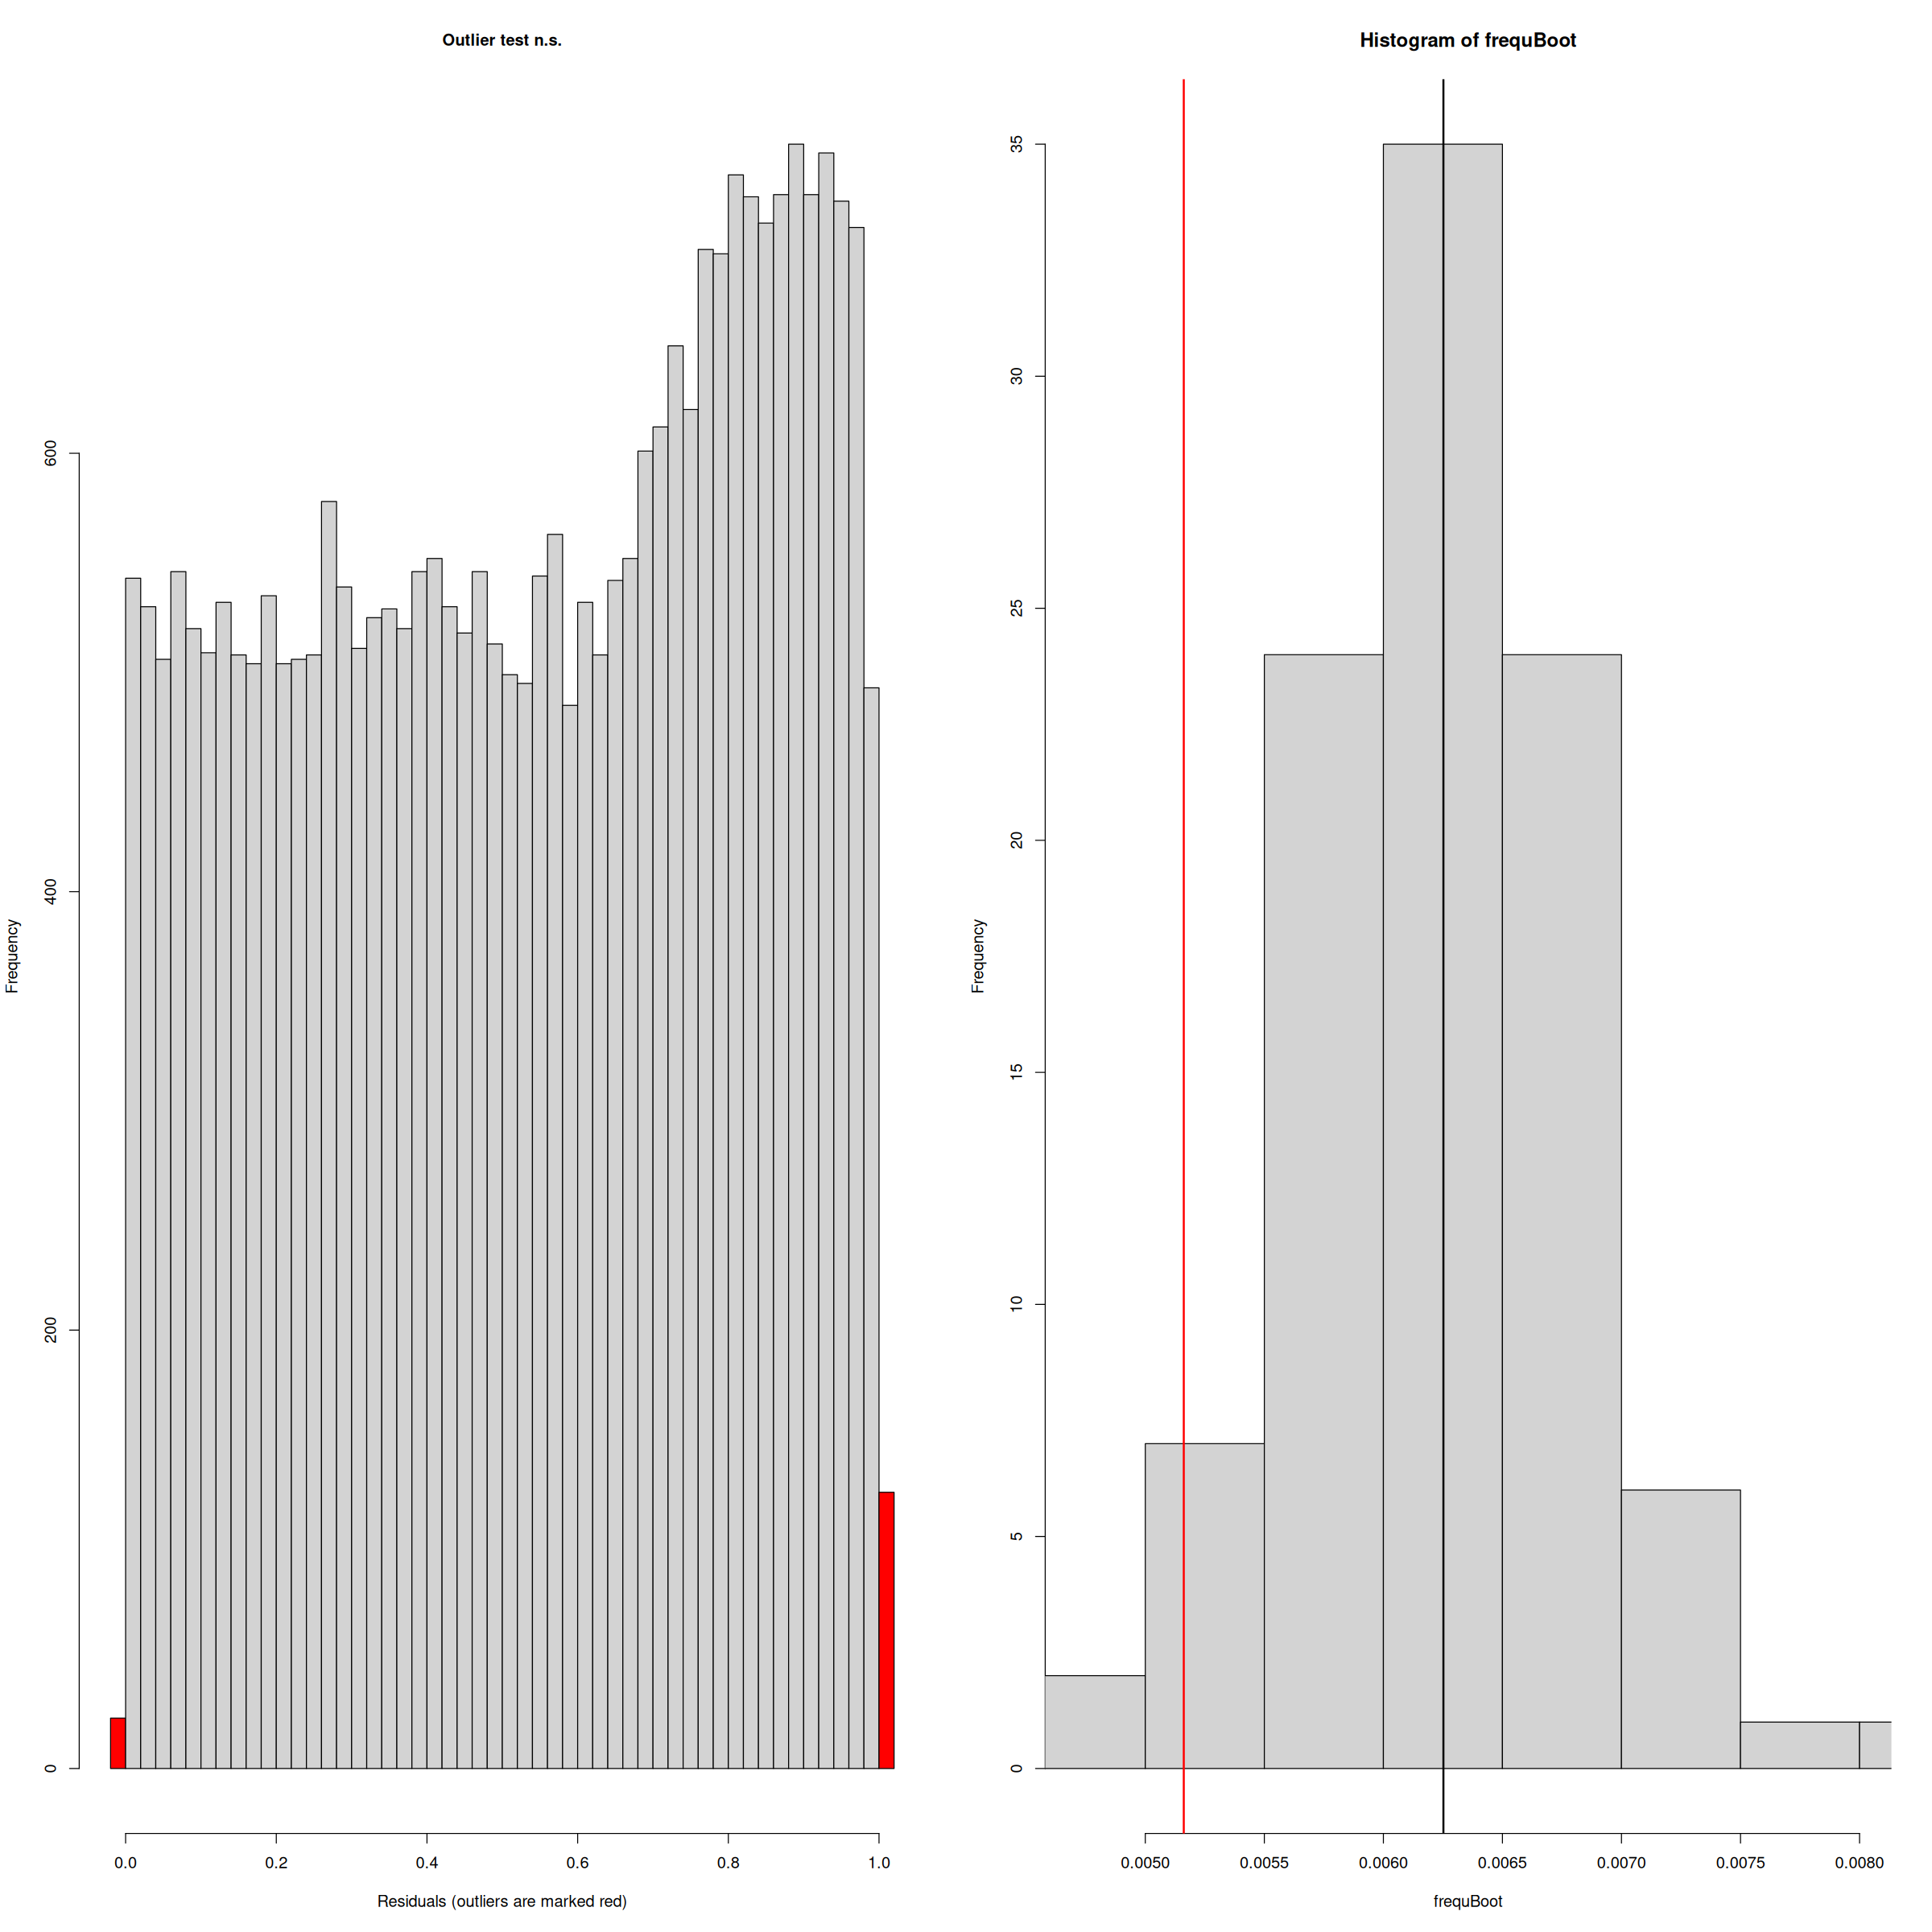

In [56]:
testOutliers(best_model_output, type='bootstrap')